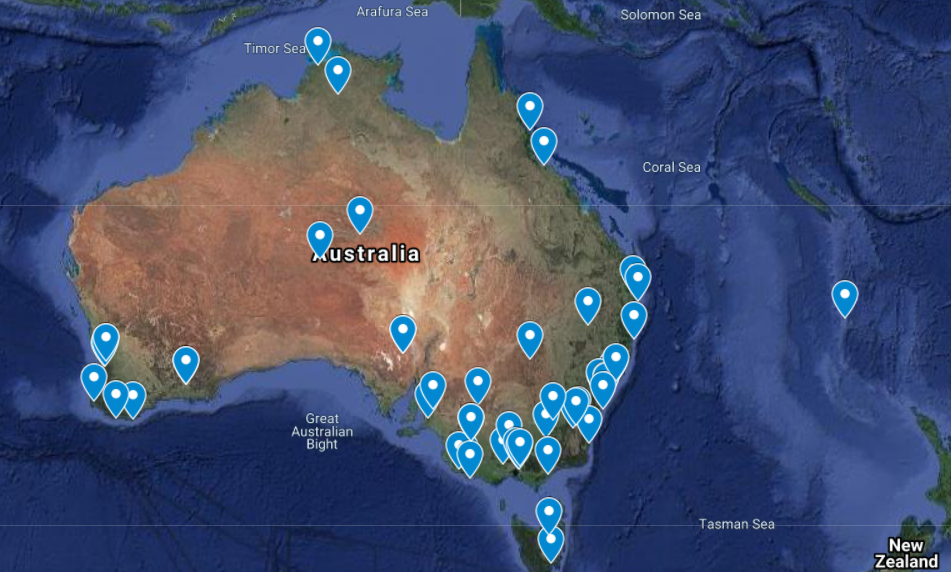

The prediction of rain was always an important task that humanity tries to deal with. The Australian Bureau of Meteorology collects a lot of data published on [kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).

 The goal is to **explore today's data and predict if tomorrow there will be rain or not.**


In this notebook, we enriched the data and added many new features based on geography and climate. In the EDA, we explored many features and their effect on rain the next day.

This notebook was created by:


*   Gal Merom
*   Hanoch Gendelman




# Imports

Imort the data science tools  - used for creating charts 

In [80]:
import sys
import shutil

shutil.rmtree('Data-Science-Tools',ignore_errors=True)

!git clone https://github.com/galmerom/Data-Science-Tools.git
SourceCodePath2 = 'Data-Science-Tools'
sys.path.insert(2, SourceCodePath2 )


Cloning into 'Data-Science-Tools'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 351 (delta 39), reused 44 (delta 20), pack-reused 288
Receiving objects: 100% (351/351), 772.91 KiB | 3.02 MiB/s, done.
Resolving deltas: 100% (212/212), done.


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from xgboost import XGBClassifier
%matplotlib inline
from datetime import timedelta
from datetime import datetime
import calendar
from collections import defaultdict
from google.colab import files
import sys
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import charts
import transformers as TR
import mega_classifier as MC

In [82]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [83]:
my_path = '/gdrive/My Drive/Colab Notebooks/Projects/Classification/Ausralia'

## Read data - Original data + data enrichment file.

In [84]:
data = pd.read_csv(my_path+'/weatherAUS.csv', squeeze=True,parse_dates =[0])
Locations = pd.read_excel(my_path+'/LocationsAndClimate.xlsx', squeeze=True)


In [85]:
data.head(5)


Date Location  MinTemp  ...  RainToday  RISK_MM  RainTomorrow
0 2008-12-01   Albury     13.4  ...         No      0.0            No
1 2008-12-02   Albury      7.4  ...         No      0.0            No
2 2008-12-03   Albury     12.9  ...         No      0.0            No
3 2008-12-04   Albury      9.2  ...         No      1.0            No
4 2008-12-05   Albury     17.5  ...         No      0.2            No

[5 rows x 24 columns]

Number of weather stations

In [86]:
len(data.Location.unique())

49

In [87]:
Locations.head()

Location       Same as  ... Distance_from_Sea Climate
0       Adelaide      Adelaide  ...              9.70     Csa
1         Albany        Albany  ...             10.50     Csb
2         Albury        Albury  ...            277.70     Cfa
3   AliceSprings  AliceSprings  ...            882.00     Bwh
4  BadgerysCreek        Sydney  ...             42.45     Cfb

[5 rows x 10 columns]

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        141556 non-null  float64       
 3   MaxTemp        141871 non-null  float64       
 4   Rainfall       140787 non-null  float64       
 5   Evaporation    81350 non-null   float64       
 6   Sunshine       74377 non-null   float64       
 7   WindGustDir    132863 non-null  object        
 8   WindGustSpeed  132923 non-null  float64       
 9   WindDir9am     132180 non-null  object        
 10  WindDir3pm     138415 non-null  object        
 11  WindSpeed9am   140845 non-null  float64       
 12  WindSpeed3pm   139563 non-null  float64       
 13  Humidity9am    140419 non-null  float64       
 14  Humidity3pm    138583 non-null  float64       
 15  

In [89]:
Locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           49 non-null     object 
 1   Same as            49 non-null     object 
 2   Nearest location   49 non-null     object 
 3   Area               49 non-null     object 
 4   Latitude           49 non-null     float64
 5   Long               49 non-null     float64
 6   Height             49 non-null     int64  
 7   rain_district      49 non-null     object 
 8   Distance_from_Sea  49 non-null     float64
 9   Climate            49 non-null     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 4.0+ KB


## Exploring NULLs

Many many NULLs in almost every feature

In [90]:
data.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

# Split to train and test - for EDA

Split the data to training set and test set by date.

In [91]:
data.sort_values(by='Date',inplace=True)
data_train=data.iloc[0:113747,:] # 80% train 20% test
data_test=data.iloc[113748:,:]

Check if, after the split, we have the same class ratio.

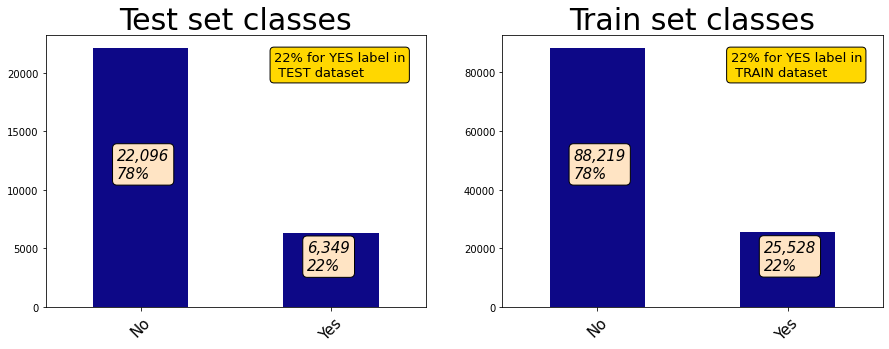

In [92]:
TestClass=data_test['RainTomorrow'].value_counts()
TrainClass=data_train['RainTomorrow'].value_counts()
charts.BarCharts([TestClass,TrainClass],['Test set classes','Train set classes'],1,2,txt2show=[('22% for YES label in\n TEST dataset', 13,0.6,-0.15),('22% for YES label in\n TRAIN dataset', 13,0.6,-0.15)]) 

Copy the data to a new dataset to avoid accidentally change of the original data

In [93]:
data_train4EDA = data_train.copy()

# Transformers

## Change "wind Direction" columns to integer

In [94]:
from sklearn.base import BaseEstimator, TransformerMixin
class DirectionTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.DirecDict = {'N':0,'NNE':1,'NE':2,'ENE':3,'E':4,'ESE':5,'SE':6,'SSE':7,'S':8,'SSW':9,'SW':10,'W':11,'WSW':12,'WNW':13,'NW':14,'NNW':15}
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    X_new['WindGustDir']=X_new['WindGustDir'].apply(self.ChangeWindDirec2Int)
    X_new['WindDir3pm']=X_new['WindDir3pm'].apply(self.ChangeWindDirec2Int)
    X_new['WindDir9am']=X_new['WindDir9am'].apply(self.ChangeWindDirec2Int)
    return X_new
  def ChangeWindDirec2Int(self,x):
    try:
      return self.DirecDict[x]
    except:
      return x

In [95]:
DirectTransformer = DirectionTransformer()
data_train4EDA=DirectTransformer.transform(data_train4EDA)

## Merge with the locations data

Merge the original data and the location data (the data enrichment)

In [96]:
class MergeLocationTransformer(BaseEstimator, TransformerMixin):
  def __init__(self,Locations):
    self.Location = Locations
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    X_new= pd.merge(X_new,self.Location, on='Location',how ='left')
    Sameasdf = X_new.groupby(['Date','Same as']).mean()
    Neardf = X_new.groupby(['Date','Nearest location']).mean()
    Areadf = X_new.groupby(['Date','Area']).mean()
    SameDaydf = X_new.groupby(['Date']).mean()
    Climatedf=X_new.groupby(['Date','Climate']).mean()
    X_new= pd.merge(X_new,Sameasdf, on=('Date','Same as'),suffixes=('', '_SameAS'),how ='left')
    X_new= pd.merge(X_new,Neardf, on=('Date','Nearest location'),suffixes=('', '_Nearest'),how ='left')
    X_new= pd.merge(X_new,Climatedf, on=('Date','Climate'),suffixes=('', '_Climate'),how ='left')
    X_new= pd.merge(X_new,Areadf, on=('Date','Area'),suffixes=('', '_Area'),how ='left')
    X_new= pd.merge(X_new,SameDaydf, on=('Date'),suffixes=('', '_All'),how ='left')
    X_new.index = X.index
    return X_new


In [97]:
MergeLocation = MergeLocationTransformer(Locations)
data_train4EDA=MergeLocation.transform(data_train4EDA)

## Impute NULLs

We have many features with many Nulls. The worst have 47% Nulls.

To fill this number, we will take the missing data from the following features by this order:

(stop searching if a non NULL value exists)
 

1.   A very close station
2.   The nearest station
3.   Stations that have the same climate (Average)
4.   Stations that have the same 'Area' (Average)
5.   If all of the above is NULL, then put zero



In [98]:
class impute_nullsTransformer(BaseEstimator, TransformerMixin):
  def __init__(self,WithTargetCol=True):
    self.df=pd.DataFrame()
    self.IncldTrgtcol=WithTargetCol
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    self.df = X_new
    AllCol = X_new.columns.to_list()
    ColList = [AllCol[i] for i in range(2,21)]
    list(map(self.impute_nulls, ColList))
    # Update the target column to follow the rules over 1 mm is rain
    X_new.loc[:,'RainToday'] = np.where(X_new.loc[:,'Rainfall']>1,'Yes','No')
    
    # remove extra columns
    if self.IncldTrgtcol:
      X_new=X_new.iloc[:,0:33]
    else:
      X_new=X_new.iloc[:,0:31]

    return X_new

  def impute_nulls(self,col_name):
    df=self.df
    prefixes = ['_SameAS','_Nearest','_Climate','_Area','_All']
    # Go over the column that was given as a parameter. When you find null: go over all the prefixes in the right order
    # and put the value that is in that col_name+prefix. If there is null there then in the next iteration, it will be fixed with 
    # the next prefix.
    for pf in prefixes:
      df.loc[:,col_name] = np.where(df.loc[:,col_name].isnull(),
                                    df[col_name+pf],
                                    df[col_name])
    # In case there are still nulls, then give them the value of zero
    df.loc[:,col_name] = np.where(df.loc[:,col_name].isnull(),
                                  0,
                                  df[col_name])

In [99]:
ImputeNulls = impute_nullsTransformer()
data_train4EDA=ImputeNulls.transform(data_train4EDA)

Make sure there are no NULLs.

In [100]:
data_train4EDA.loc[data_train4EDA.isnull().any(axis=1),:]

Empty DataFrame
Columns: [Date, Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, RISK_MM, RainTomorrow, Same as, Nearest location, Area, Latitude, Long, Height, rain_district, Distance_from_Sea, Climate]
Index: []

## Breaking point

We use the breaking point to back up all the data manipulation we did.

In [101]:
data_train4EDA.to_csv("No_nulls.csv")

In [102]:
df2= pd.read_csv("No_nulls.csv",index_col=0)#,parse_dates =[1])


# EDA

In [103]:
df2.describe()

MinTemp        MaxTemp  ...         Height  Distance_from_Sea
count  113747.000000  113747.000000  ...  113747.000000      113747.000000
mean       11.951691      22.960936  ...     159.730709          96.069849
std         6.370907       7.031628  ...     291.852984         172.732675
min        -8.500000      -4.100000  ...       3.000000           0.170000
25%         7.400000      17.800000  ...      16.000000           1.670000
50%        11.800000      22.300000  ...      42.000000          20.250000
75%        16.600000      27.900000  ...     195.000000         106.800000
max        33.900000      48.100000  ...    1763.000000         882.000000

[8 rows x 24 columns]

## Exploring the differences between the weather stations by locations

### Exploring by feature 'area'

*   The chances of raining in the central area of Australia is only 7%
*   The chances of raining on the Island east of Australia is about a third higher than the rest of the areas

In [104]:
dfArea=pd.crosstab( df2['Area'],df2['RainTomorrow'], normalize='index')
dfArea.style.set_precision(2).background_gradient(cmap='Blues')

### Exploring by feature  'rain_district'

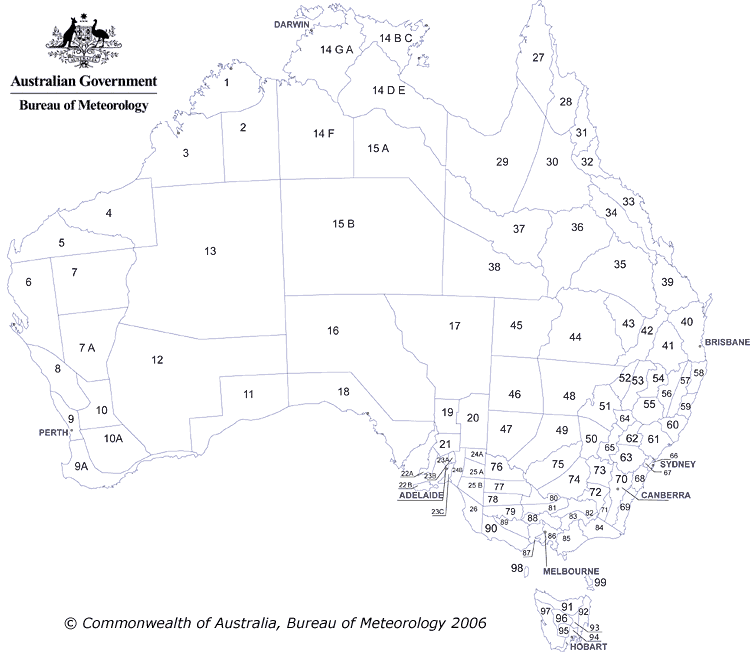

Find the number of stations in each rain district.

In [105]:
tmp=df2.groupby(['rain_district','Location']).max()['Height'].reset_index()
tmp.groupby('rain_district').count()['Location'].to_frame().transpose()

rain_district  100  10A  14GA  15B  21  23A  23C  ...  86  87  9  90  91  94  9A
Location         1    1     2    2   1    1    1  ...   4   1  4   3   1   1   2

[1 rows x 30 columns]

It seems that we don't get much more information than using the area column

In [106]:
dfRD=pd.crosstab( df2['RainTomorrow'],df2['rain_district'], normalize='columns')
dfRD.style.set_precision(2).background_gradient(cmap='Blues')

### Exploring by feature ' Climate'

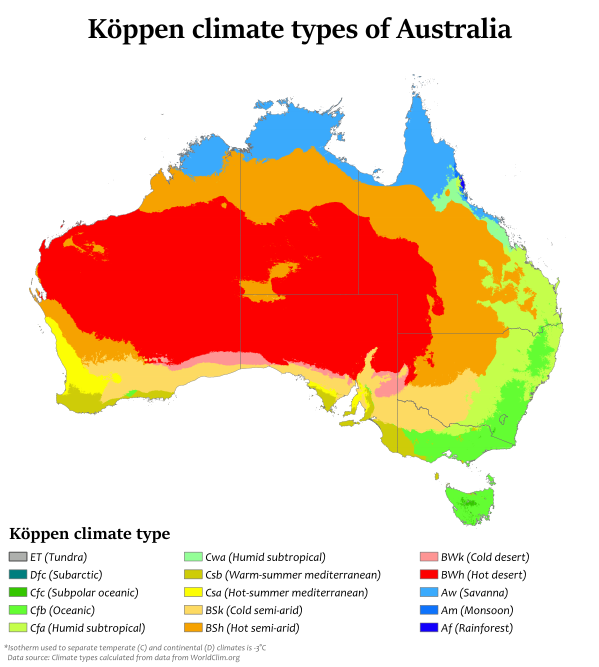

Number of stations in each climate

In [107]:
tmp2=df2.groupby(['Climate','Location']).max()['Height'].reset_index()
tmp2.groupby('Climate').count()['Location'].to_frame().transpose()

Climate   Am  Aw  Bsh  Bsk  Bwh  Cfa  Cfb  Csa  Csb
Location   1   3    2    2    2   10   17    4    8

That seems to be a very good indication to help predict the target

In [108]:
dfRD=pd.crosstab( df2['RainTomorrow'],df2['Climate'], normalize='columns')
dfRD.style.set_precision(2).background_gradient(cmap='Blues')

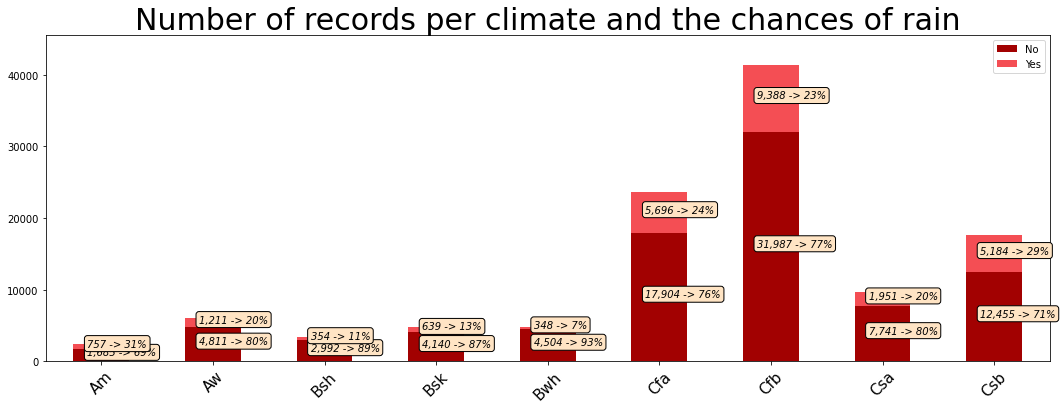

In [109]:
ClimateDF=df2.groupby(['RainTomorrow','Climate']).count()['Date'].reset_index()
charts.StackBarCharts([(ClimateDF,'Climate','RainTomorrow','Date')],['Number of records per climate and the chances of rain'],ChartSize=(18, 6))

### Exploring by feature 'Height'

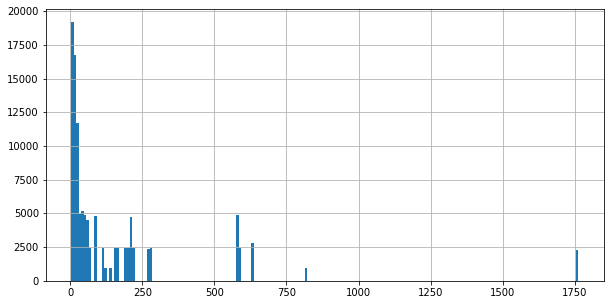

In [110]:
df2.Height.hist(bins= 200,figsize=(10,5))

Using bins to aggregate 

In [111]:
def HeightCatg(x):
  if x<=40:
    return '0000-0040'
  elif x<= 260:
    return '0040-0260'
  elif x<= 1000:
    return '0260-1000'
  else:
     return '1000+'

df2['HeightCategory']=  df2['Height'].apply(lambda x: HeightCatg(x))
dfHeight = df2.groupby(['HeightCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

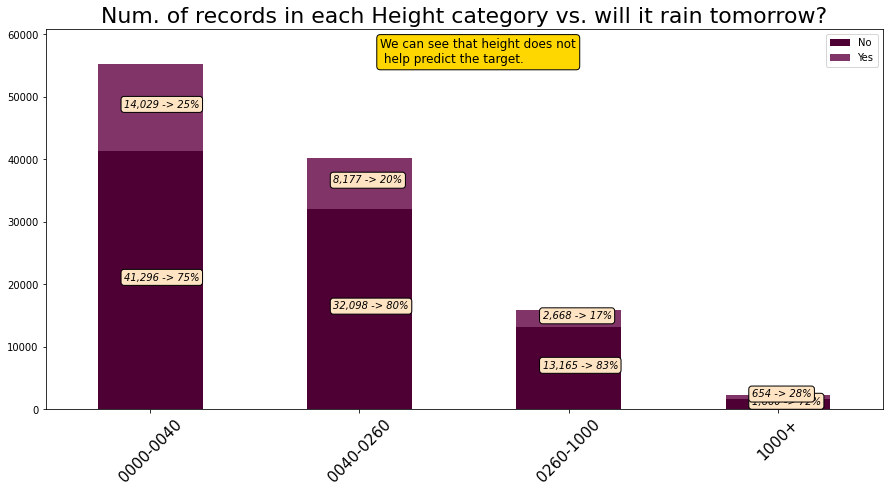

In [112]:
charts.StackBarCharts([(dfHeight,'HeightCategory','RainTomorrow','Location')],['Num. of records in each Height category vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ColorInt=3,ChartSize=(15,7),TitleSize =22,txt2show=[('We can see that height does not\n help predict the target.',12, 0.4,-0.09)])

###  Exploring by feature  'distance from the sea'

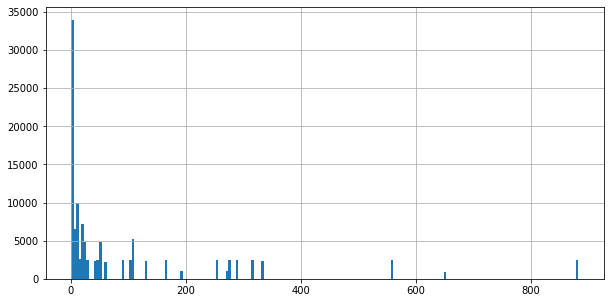

In [113]:
df2.Distance_from_Sea.hist(bins= 200,figsize=(10,5))

Using bins to aggregate 

In [114]:
def DisFromSeaCatg(x):
  if x<=0:
    return '000-000'
  elif x<= 40:
    return '000-040'
  elif x<= 100:
    return '040-100'
  elif x<= 200:
    return '100-200'  
  else:
     return '500+'

df2['DisFromSeaCategory']=  df2['Distance_from_Sea'].apply(lambda x: DisFromSeaCatg(x))
dfDisFromSea = df2.groupby(['DisFromSeaCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

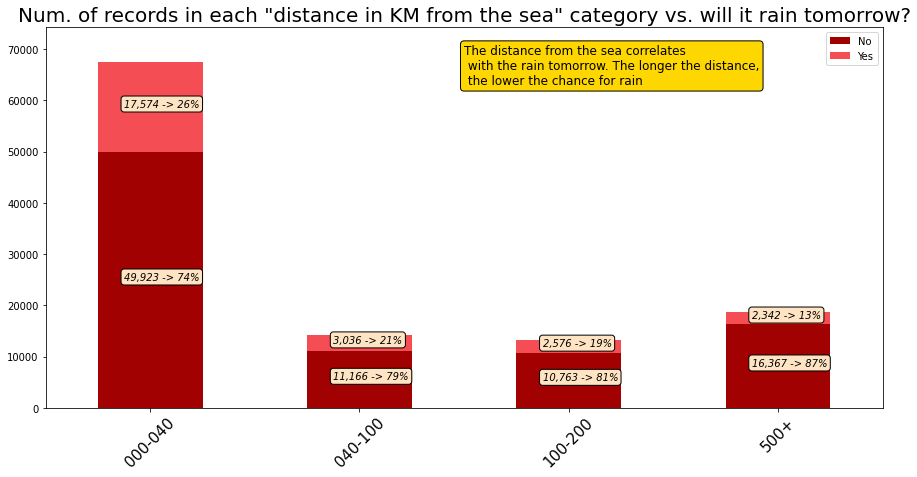

In [115]:
charts.StackBarCharts([(dfDisFromSea,'DisFromSeaCategory','RainTomorrow','Location')],['Num. of records in each \"distance in KM from the sea\" category vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),TitleSize =20,txt2show=[('The distance from the sea correlates\n with the rain tomorrow. The longer the distance,\n the lower the chance for rain',12, 0.5,-0.15)]) 

## Correlations

Exploring the correlations between the different parameters:


*   Obviously, Temp. parameters correlate to other Temp parameters
*   We'll explore the parameters that correlate to the target parameter RISK_MM:


1.   The most correlated parameter is Rainfall. So if there were rainfall today, we would see a 30% correlation to tomorrow's rain's value.
2.   The next correlated parameter is obviously sunshine

We need to remember that the correlation looks for a connection between 2 sets of numbers. But we are looking for a binary result was there rain the next day or not. Look at the chart of the evaporation parameter. Although the correlation is only 0.04, the increase in evaporation reduces the chance of raining.

Adding a binary column for RainTomorrow will help us find the correlation.

In [116]:
df2['Month'] = pd.DatetimeIndex(df2['Date']).month
df2['TommrRainBin']=np.where(df2['RainTomorrow']=='Yes',1,0)

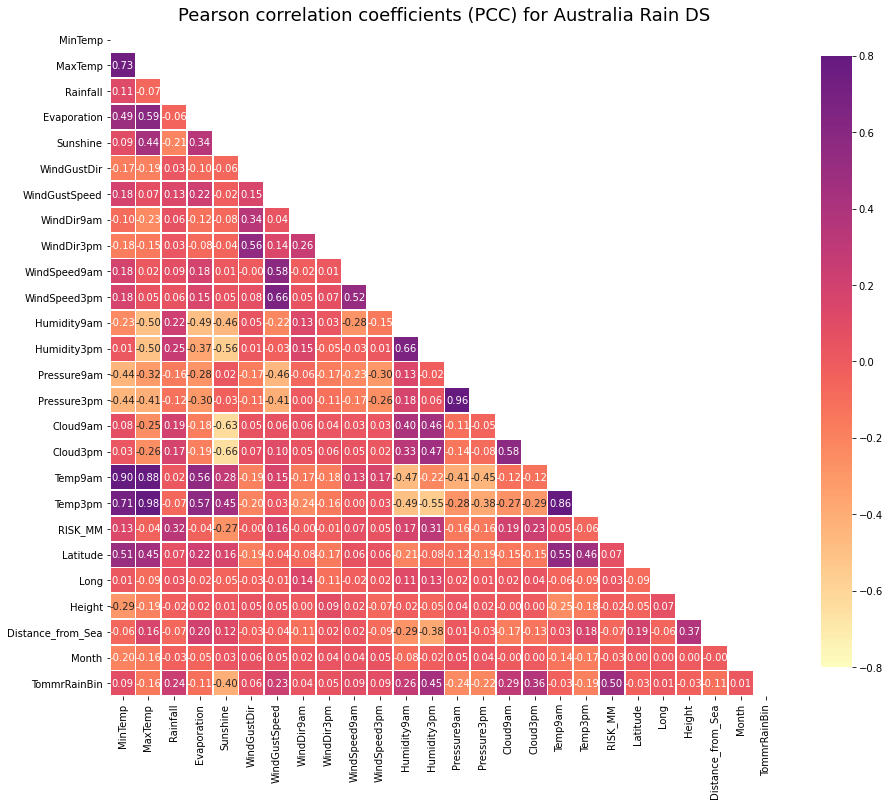

In [117]:
num_corr = df2.select_dtypes(include=np.number).corr()
fig, ax = plt.subplots(figsize=(15, 15))
title = 'Pearson correlation coefficients (PCC) for Australia Rain DS'
plt.title(title, fontsize=18)

mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

heat_map = sns.heatmap(num_corr, ax=ax, annot=True, linewidths=0.7, fmt='.2f', vmin=-0.80, vmax=0.8,
                       cmap='magma_r', mask=mask, center=0.35, cbar_kws={"shrink": 0.75}, square=True)
plt.show()

## Exploring original features with high correlation

### Sunshine

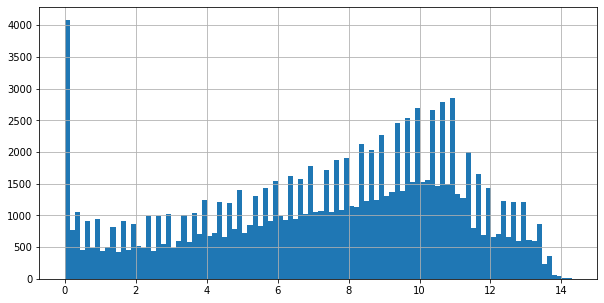

In [118]:
df2['Sunshine'].hist(bins= 100,figsize=(10,5))

Using bins to aggregate 

In [119]:
def SunshineCatg(x):
  if x<=0.0:
    return '00-00'
  elif x<= 4:
    return '00-04'
  elif x<= 8.0:
    return '04-08'
  elif x<= 11.0:
    return '08-11'
  else:
     return '11+'

df2['SunshineCategory']=  df2['Sunshine'].apply(lambda x: SunshineCatg(x))
dfSun = df2.groupby(['SunshineCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

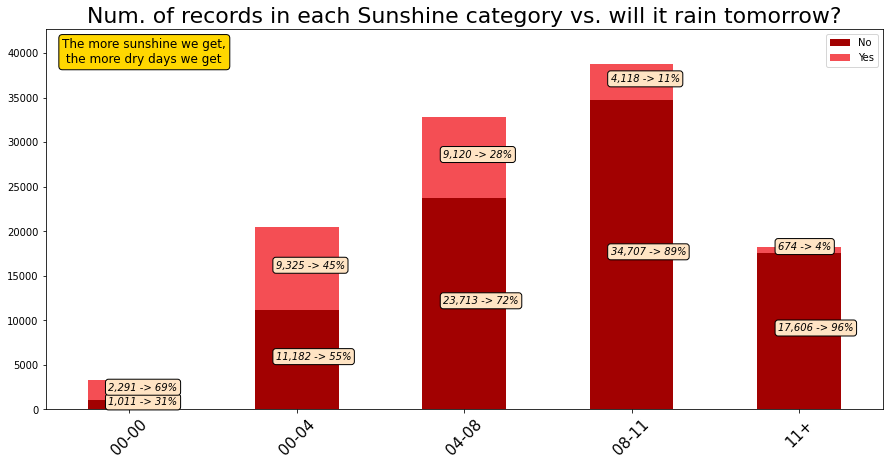

In [120]:
charts.StackBarCharts([(dfSun,'SunshineCategory','RainTomorrow','Location')],['Num. of records in each Sunshine category vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),TitleSize =22,txt2show=[('The more sunshine we get,\n the more dry days we get',12, 0.02,-0.09)])

### Evaporation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10eb5d5210>]],
      dtype=object)

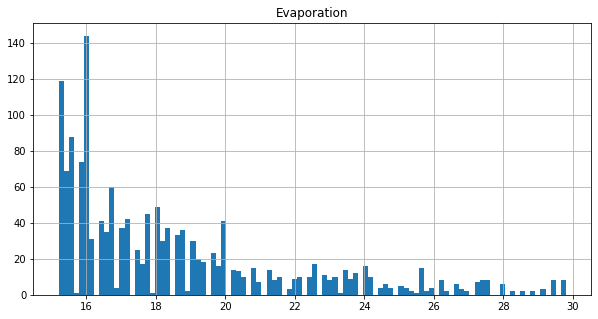

In [121]:
df2[(df2['Evaporation']<30)&(df2['Evaporation']>15)].hist(column='Evaporation',bins= 100,figsize=(10,5))

Using bins to aggregate 

In [122]:
def EvapCatg(x):
  if x<=0.0:
    return '00-00'
  elif x<= 2:
    return '00-02'
  elif x<= 5.0:
    return '02-05'
  elif x<= 10.0:
    return '05-10'
  elif x<=30.0:
    return '11-30'
  else:
     return '30+'

df2['EvaporationCategory']=  df2['Evaporation'].apply(lambda x: EvapCatg(x))
dfEvap = df2.groupby(['EvaporationCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

**As the Evaporation value increases we get less chances of raining**

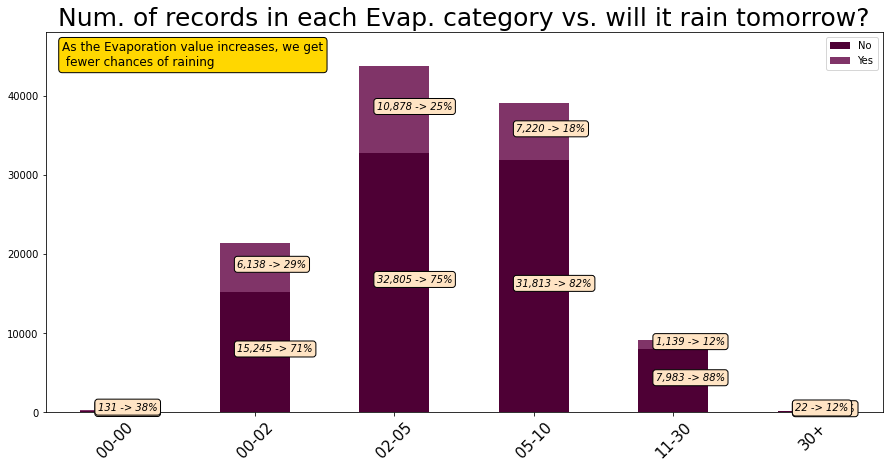

In [123]:
charts.StackBarCharts([(dfEvap,'EvaporationCategory','RainTomorrow','Location')],['Num. of records in each Evap. category vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),ColorInt=3,TitleSize =25,txt2show=[('As the Evaporation value increases, we get\n fewer chances of raining',12, 0.02,-0.09)])

### rain fall

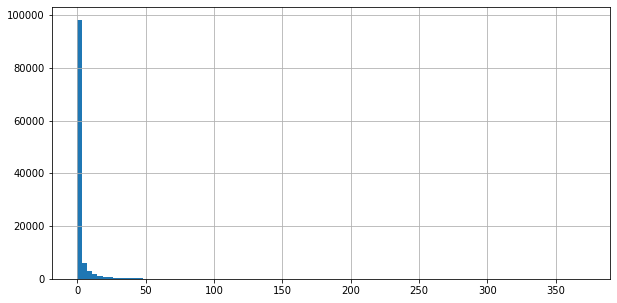

In [124]:
df2.Rainfall.hist(bins= 100,figsize=(10,5))

Removing the tail

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10eb3ea450>]],
      dtype=object)

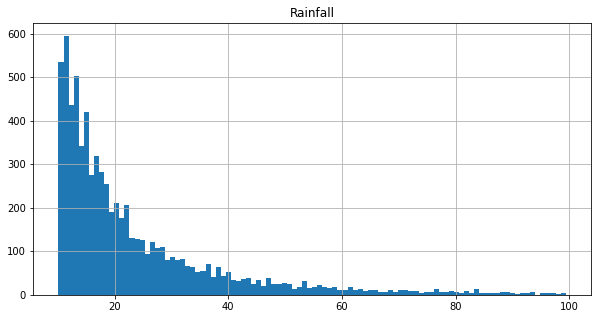

In [125]:
df2[(df2['Rainfall']<100)&(df2['Rainfall']>10)].hist(column='Rainfall',bins= 100,figsize=(10,5))

Using bins to aggregate 

In [126]:
def RainfallCatg(x):
  if x<=1:
    return '00-01'
  elif x<= 15:
    return '01-15'
  elif x<= 60:
    return '15-60'
  else:
     return '60+'

df2['RainfallCategory'] =  df2['Rainfall'].apply(lambda x: RainfallCatg(x))
dfRF = df2.groupby(['RainfallCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

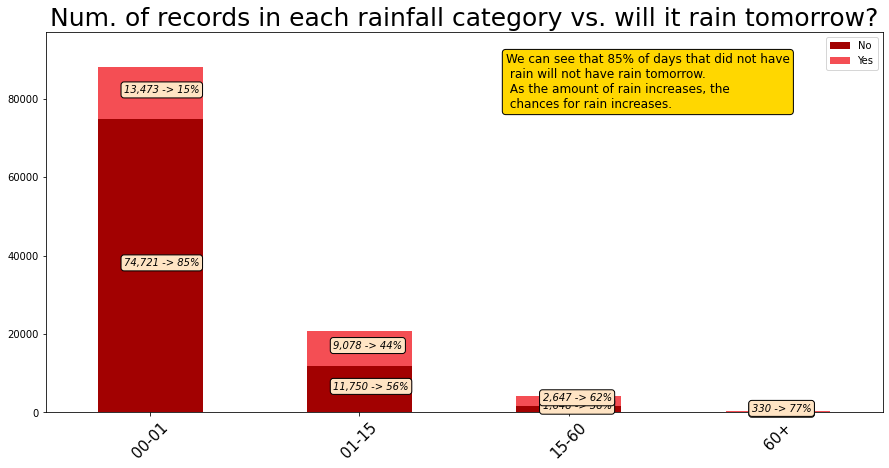

In [127]:
charts.StackBarCharts([(dfRF,'RainfallCategory','RainTomorrow','Location')],['Num. of records in each rainfall category vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),TitleSize =25,txt2show=[('We can see that 85% of days that did not have\n rain will not have rain tomorrow.\n As the amount of rain increases, the\n chances for rain increases.',12, 0.55,-0.20)])

#### Exploring 'rain fall' with 'distance from the sea'

In [128]:
dfRFDFTS = df2[df2['Rainfall']>15].groupby(['DisFromSeaCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

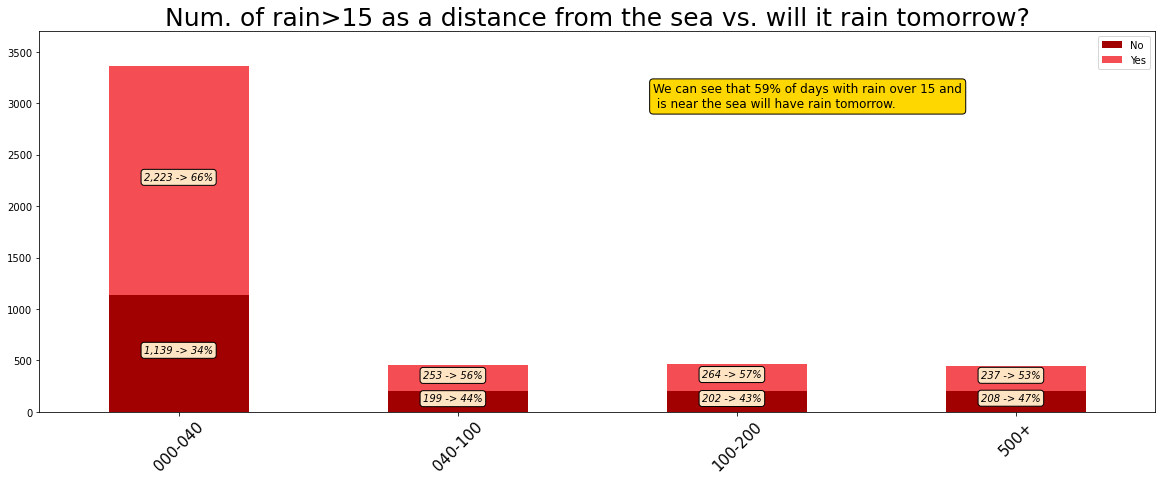

In [129]:
charts.StackBarCharts([(dfRFDFTS,'DisFromSeaCategory','RainTomorrow','Location')],['Num. of rain>15 as a distance from the sea vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(20,7),TitleSize =25,txt2show=[('We can see that 59% of days with rain over 15 and\n is near the sea will have rain tomorrow.',12, 0.55,-0.20)]) 

#### Explore rain fall and area

In [130]:
dfAreaRF = df2[df2['Rainfall']>15].groupby(['Area','RainTomorrow']).count()['Location'].to_frame().reset_index()

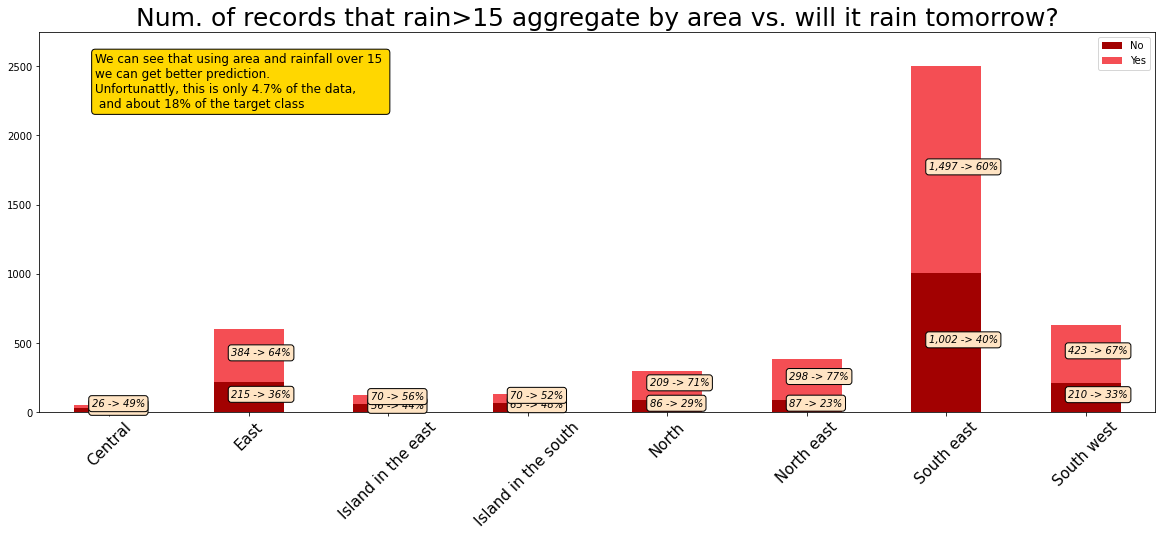

In [131]:
charts.StackBarCharts([(dfAreaRF,'Area','RainTomorrow','Location')],['Num. of records that rain>15 aggregate by area vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(20,7),TitleSize =25,txt2show=[('We can see that using area and rainfall over 15 \nwe can get better prediction.\nUnfortunattly, this is only 4.7% of the data,\n and about 18% of the target class',12, 0.05,-0.2)])

### humidity3pm

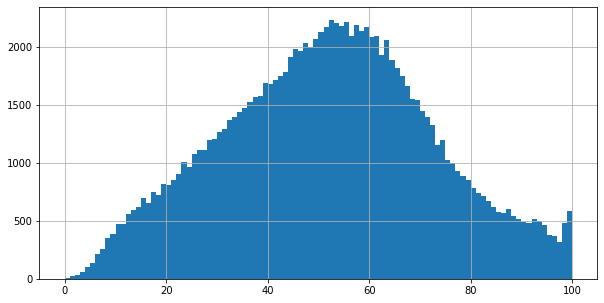

In [132]:
df2.Humidity3pm.hist(bins= 100,figsize=(10,5))

Using bins to aggregate 

In [133]:
def HumidityCatg(x):
  if x<=20:
    return '00-20'
  elif x<= 40:
    return '20-40'
  elif x<= 60:
    return '40-60'
  elif x<= 80:
    return '60-80'
  else:
     return '80+'

df2['HumidityCategory'] =  df2['Humidity3pm'].apply(lambda x: HumidityCatg(x))
dfHmdty = df2.groupby(['HumidityCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

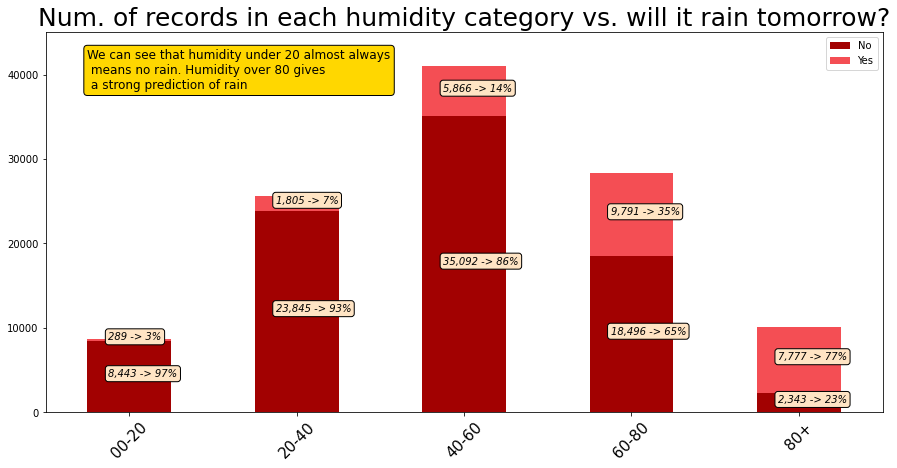

In [134]:
charts.StackBarCharts([(dfHmdty,'HumidityCategory','RainTomorrow','Location')],['Num. of records in each humidity category vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),TitleSize =25,txt2show=[('We can see that humidity under 20 almost always\n means no rain. Humidity over 80 gives\n a strong prediction of rain',12, 0.05,-0.15)])

#### Exploring humidity under 40 with area

In [136]:
dfAreHum=df2[df2['Humidity3pm']<40].groupby(['Area','RainTomorrow']).count()['Location'].to_frame().reset_index()

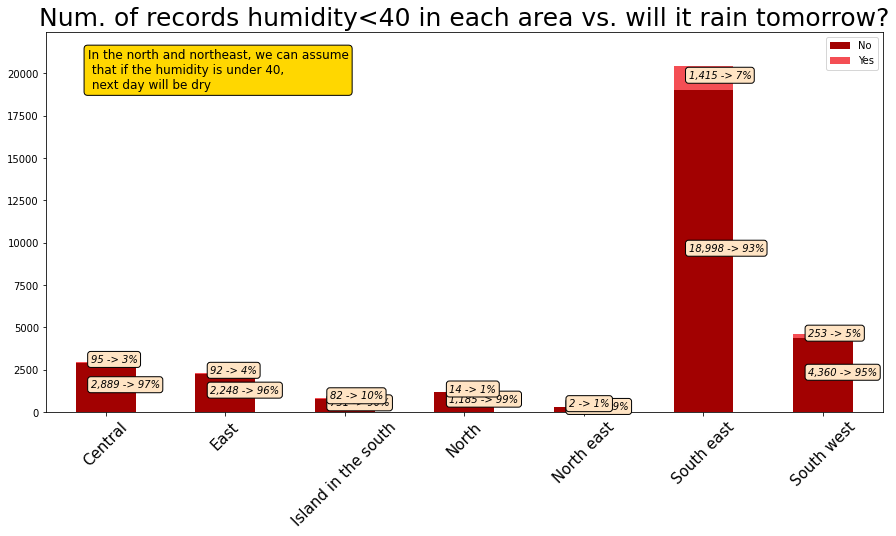

In [137]:
charts.StackBarCharts([(dfAreHum,'Area','RainTomorrow','Location')],['Num. of records humidity<40 in each area vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),TitleSize =25,txt2show=[('In the north and northeast, we can assume\n that if the humidity is under 40,\n next day will be dry',12, 0.05,-0.15)])

Let explore humidity under 40 with Climate

In [138]:
dfHumlimate=df2[(df2['Humidity3pm']<40)].groupby(['Climate','RainTomorrow']).count()['Location'].to_frame().reset_index()

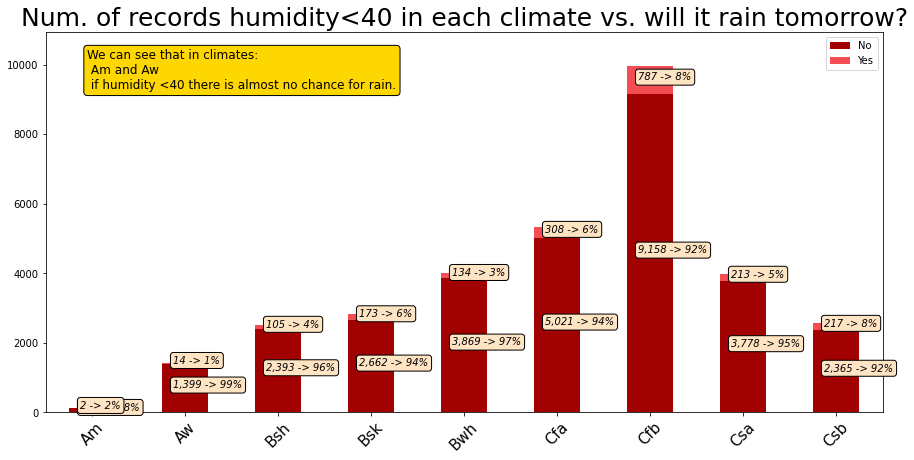

In [140]:
charts.StackBarCharts([(dfHumlimate,'Climate','RainTomorrow','Location')],['Num. of records humidity<40 in each climate vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),TitleSize =25,txt2show=[('We can see that in climates:\n Am and Aw\n if humidity <40 there is almost no chance for rain.',12, 0.05,-0.15)])

**We know for sure** that Humidity3pm <25 in the following climates will have no rain the next day:


*   Am
*   Aw



In [141]:
df2[(df2['Humidity3pm']<25)&((df2['Climate']=='Aw')|(df2['Climate']=='Am'))].groupby('RainTomorrow').count()['Location']

RainTomorrow
No    507
Name: Location, dtype: int64

###  Cloud3pm - measered in okta. Zero means the sky have no clouds. 8 means the sky is covered

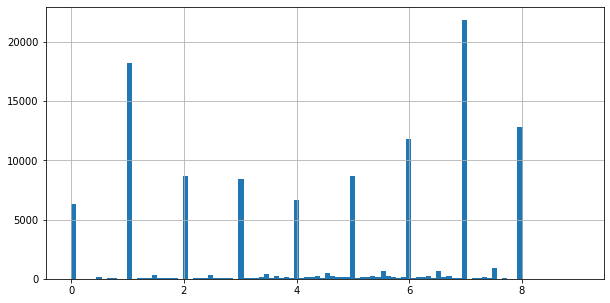

In [142]:
df2.Cloud3pm.hist(bins= 100,figsize=(10,5))

Using bins to aggregate 

In [168]:
def CloudCatg(x):
  if x<=0:
    return '0'
  elif x<= 1:
    return '0-1'
  elif x<= 2:
    return '2-4'
  elif x<= 6:
    return '4-6'
  elif x<= 7:
    return '6-7'
  else:
     return '7+'

df2['CloudCategory'] =  df2['Cloud3pm'].apply(lambda x: CloudCatg(x))
dfCloud = df2.groupby(['CloudCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

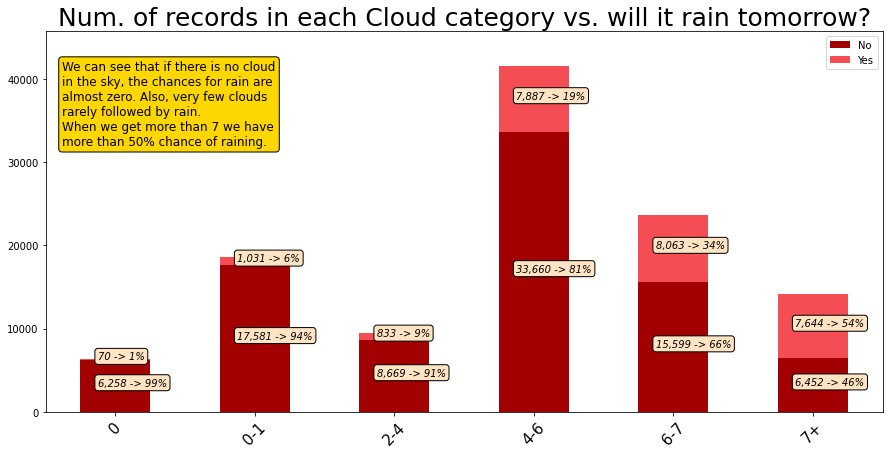

In [145]:
charts.StackBarCharts([(dfCloud,'CloudCategory','RainTomorrow','Location')],['Num. of records in each Cloud category vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),TitleSize =25,txt2show=[('We can see that if there is no cloud\nin the sky, the chances for rain are\nalmost zero. Also, very few clouds\nrarely followed by rain. \nWhen we get more than 7 we have\nmore than 50% chance of raining.',12, 0.02,-0.3)])

### 'Month' -  defining [seasons](http://www.bom.gov.au/climate/glossary/seasons.shtml)

In [147]:
def Seasons(x):
  if x in [9,10,11]:
    return 'Spring'
  elif x in [12,1,2]:
    return 'Summer'
  elif x in [3,4,5]:
    return 'Autumn'
  else:
     return 'Winter'

df2['Seasons'] =  df2['Month'].apply(lambda x: Seasons(x))
dfseason = df2.groupby(['Seasons','RainTomorrow']).count()['Location'].to_frame().reset_index()

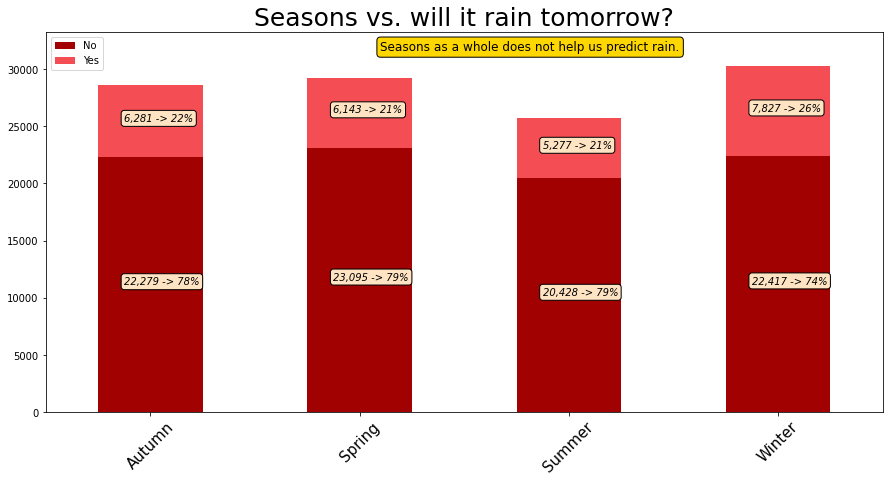

In [149]:
charts.StackBarCharts([(dfseason,'Seasons','RainTomorrow','Location')],['Seasons vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),TitleSize =25,txt2show=[('Seasons as a whole does not help us predict rain.',12, 0.40,-0.05)])

Lets explore season with Area

In [151]:
df2['SeasonArea'] = 'S: '+ df2['Seasons'] + " C: "+df2['Area']
dfseasonArea = df2[df2['Seasons']=='Winter'].groupby(['SeasonArea','RainTomorrow']).count()['Location'].to_frame().reset_index()

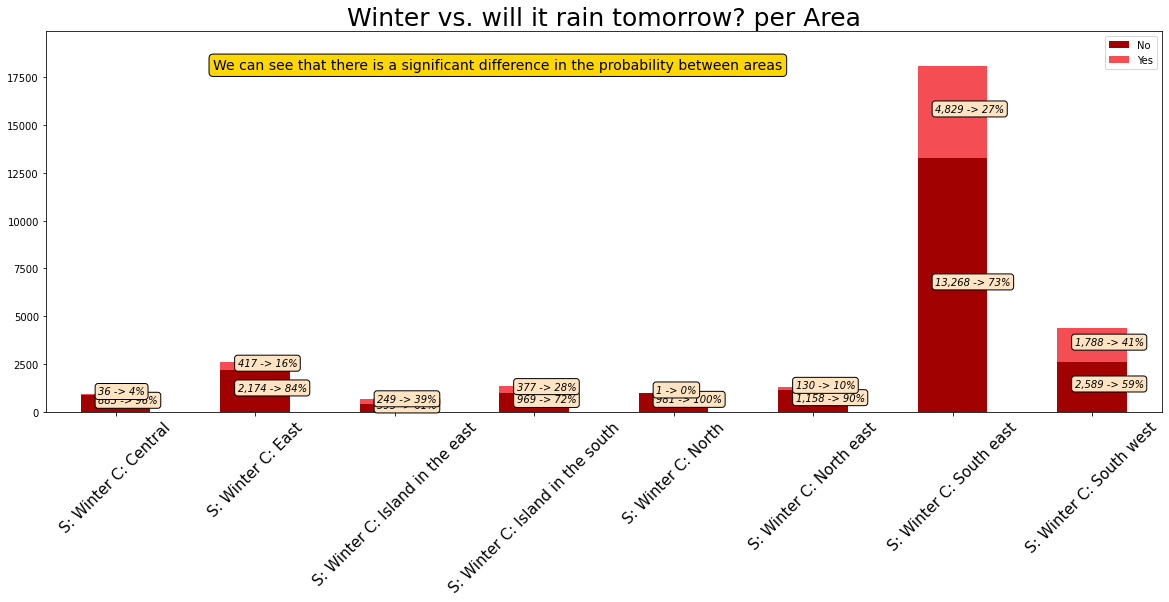

In [152]:
charts.StackBarCharts([(dfseasonArea,'SeasonArea','RainTomorrow','Location')],['Winter vs. will it rain tomorrow? per Area'],NumRows=1,NumCol=1,ColorInt=0,ChartSize=(20,7),TitleSize =25,txt2show=[('We can see that there is a significant difference in the probability between areas',14, 0.15,-0.1)])

We can assume that in the **winter** there is no rain in the North area !!

In [153]:
df2[(df2['Seasons']=='Winter')&(df2['Area']=='North')].groupby('RainTomorrow').count()['Location']

RainTomorrow
No     981
Yes      1
Name: Location, dtype: int64

In [154]:
df2['SeasonClimate'] = 'S: '+ df2['Seasons'] + " C: "+df2['Climate']
dfWinterClimate = df2[df2['Seasons']=='Winter'].groupby(['SeasonClimate','RainTomorrow']).count()['Location'].to_frame().reset_index()

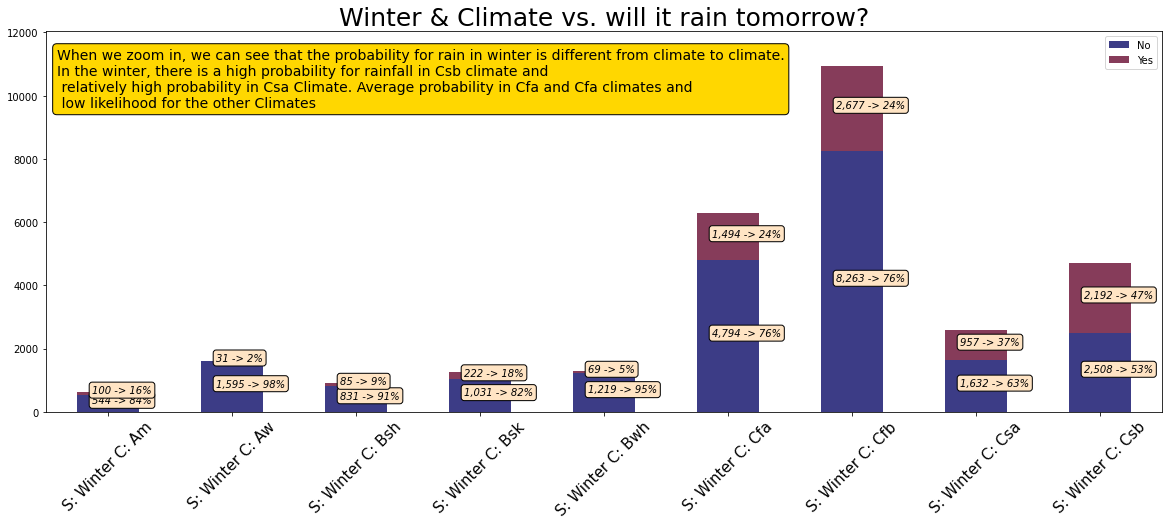

In [161]:
charts.StackBarCharts([(dfWinterClimate,'SeasonClimate','RainTomorrow','Location')],['Winter & Climate vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ColorInt=1,ChartSize=(20,7),TitleSize =25,txt2show=[('When we zoom in, we can see that the probability for rain in winter is different from climate to climate.\nIn the winter, there is a high probability for rainfall in Csb climate and\n relatively high probability in Csa Climate. Average probability in Cfa and Cfa climates and\n low likelihood for the other Climates',14, 0.01,-0.2)])

In [162]:
dfAutumnClimate = df2[df2['Seasons']=='Autumn'].groupby(['SeasonClimate','RainTomorrow']).count()['Location'].to_frame().reset_index()

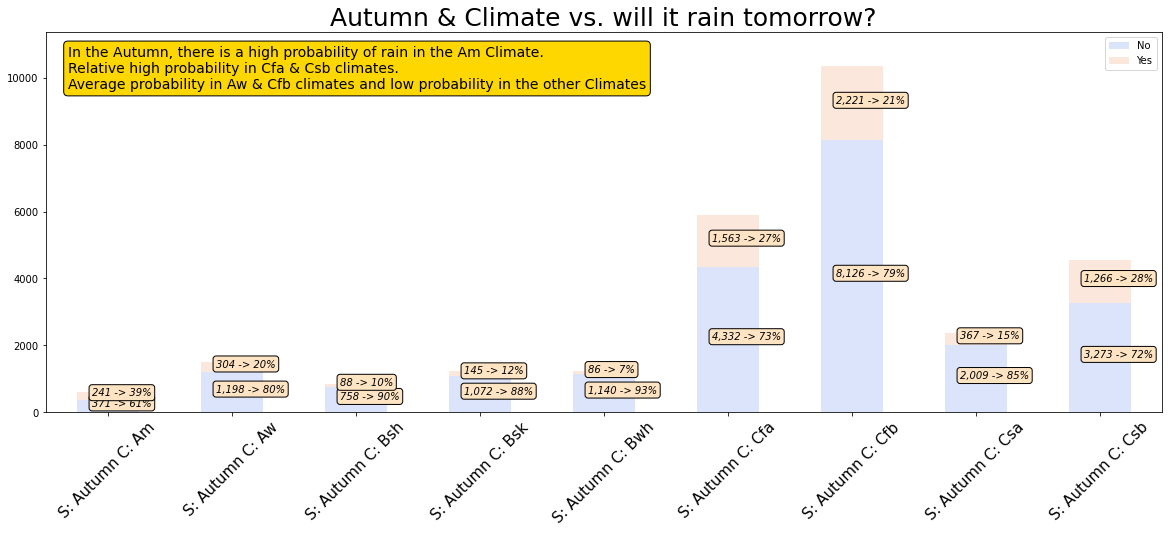

In [163]:
charts.StackBarCharts([(dfAutumnClimate,'SeasonClimate','RainTomorrow','Location')],['Autumn & Climate vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ColorInt=2,ChartSize=(20,7),TitleSize =25,txt2show=[('In the Autumn, there is a high probability of rain in the Am Climate.\nRelative high probability in Cfa & Csb climates.\nAverage probability in Aw & Cfb climates and low probability in the other Climates',14, 0.02,-0.15)])

In [164]:
dfSpringClimate = df2[df2['Seasons']=='Spring'].groupby(['SeasonClimate','RainTomorrow']).count()['Location'].to_frame().reset_index()

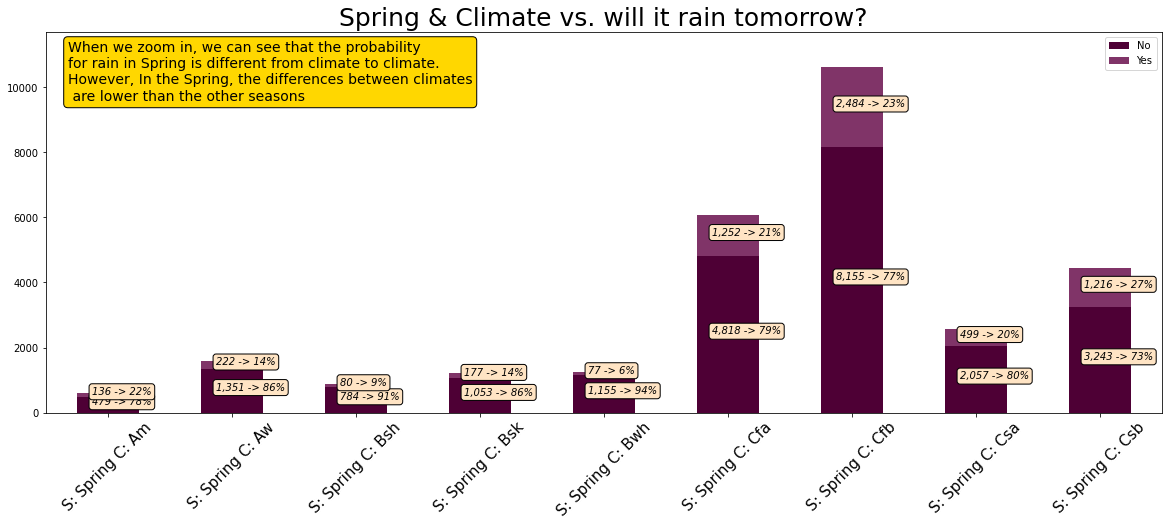

In [165]:
charts.StackBarCharts([(dfSpringClimate,'SeasonClimate','RainTomorrow','Location')],['Spring & Climate vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ColorInt=3,ChartSize=(20,7),TitleSize =25,txt2show=[('When we zoom in, we can see that the probability\nfor rain in Spring is different from climate to climate.\nHowever, In the Spring, the differences between climates\n are lower than the other seasons',14, 0.02,-0.18)])

In [166]:
dfSummerClimate = df2[df2['Seasons']=='Summer'].groupby(['SeasonClimate','RainTomorrow']).count()['Location'].to_frame().reset_index()

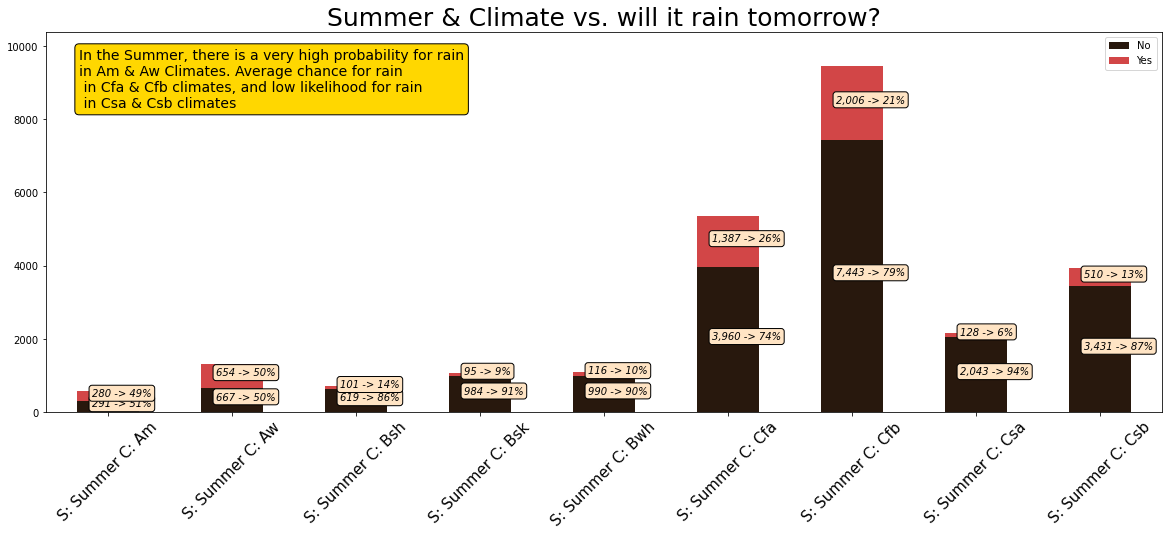

In [167]:
charts.StackBarCharts([(dfSummerClimate,'SeasonClimate','RainTomorrow','Location')],['Summer & Climate vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ColorInt=4,ChartSize=(20,7),TitleSize =25,txt2show=[('In the Summer, there is a very high probability for rain\nin Am & Aw Climates. Average chance for rain\n in Cfa & Cfb climates, and low likelihood for rain\n in Csa & Csb climates',14, 0.03,-0.2)])

#### Pressure9am

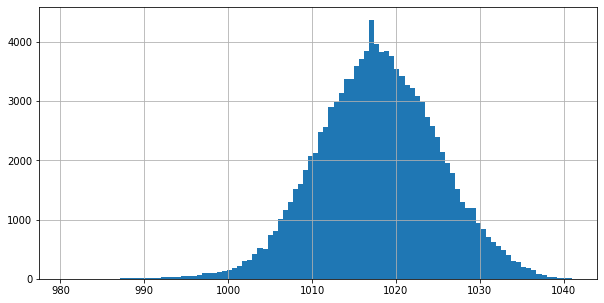

In [170]:
df2.Pressure9am.hist(bins= 100,figsize=(10,5))

Using bins to aggregate 

In [169]:
def Pressure9am(x):
  if x<=1000:
    return '0000-1000'
  elif x<= 1010:
    return '1000-1010'
  elif x<= 1020:
    return '1010-1020'
  elif x<= 1030:
    return '1020-1030'
  else:
     return '1030+'

df2['PressureCategory'] =  df2['Pressure9am'].apply(lambda x: Pressure9am(x))
dfPressure = df2.groupby(['PressureCategory','RainTomorrow']).count()['Location'].to_frame().reset_index()

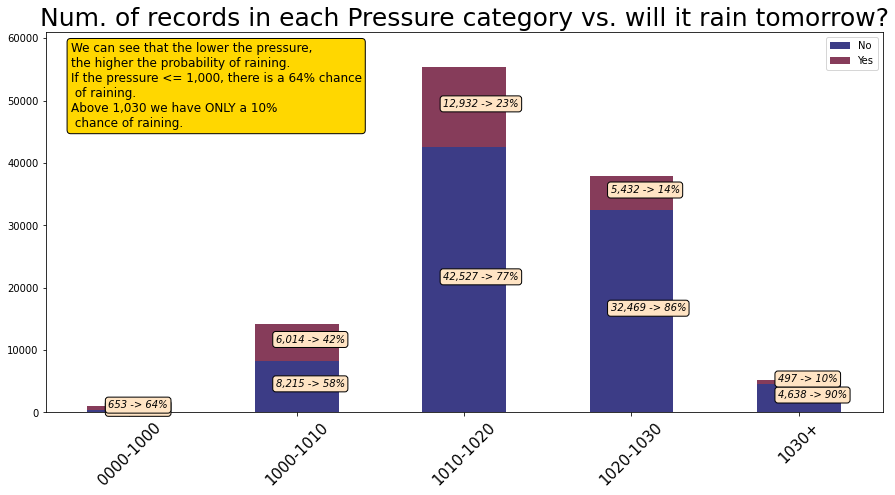

In [175]:
charts.StackBarCharts([(dfPressure,'PressureCategory','RainTomorrow','Location')],['Num. of records in each Pressure category vs. will it rain tomorrow?'],NumRows=1,NumCol=1,ChartSize=(15,7),ColorInt=1,TitleSize =25,txt2show=[('We can see that the lower the pressure,\nthe higher the probability of raining.\nIf the pressure <= 1,000, there is a 64% chance\n of raining.\nAbove 1,030 we have ONLY a 10%\n chance of raining.',12, 0.03,-0.25)])

### Location

No location had excess records. Some have about 50% less.

In [ ]:
df2.groupby('Location').count()['Date']

Location
Adelaide            2501
Albany              2437
Albury              2422
AliceSprings        2446
BadgerysCreek       2356
Ballarat            2436
Bendigo             2446
Brisbane            2575
Cairns              2442
Canberra            2826
Cobar               2409
CoffsHarbour        2360
Dartmoor            2351
Darwin              2599
GoldCoast           2419
Hobart              2594
Katherine            978
Launceston          2438
Melbourne           2013
MelbourneAirport    2415
Mildura             2413
Moree               2283
MountGambier        2446
MountGinini         2314
Newcastle           2383
Nhil                 976
NorahHead           2336
NorfolkIsland       2414
Nuriootpa           2411
PearceRAAF          2177
Penrith             2384
Perth               2599
PerthAirport        2415
Portland            2405
Richmond            2360
Sale                2412
SalmonGums          2366
Sydney              2743
SydneyAirport       2415
Townsville      

# Other Transofrmations - After EDA

The following transformer add month and year and reduces the rainfall to maximum of 100

In [176]:
class OtherChangesTransformer(BaseEstimator, TransformerMixin):
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    X_new['Month'] = pd.DatetimeIndex(X_new['Date']).month.astype(str)
    X_new['Year'] = pd.DatetimeIndex(X_new['Date']).year
    X_new['Rainfall']=np.where(X_new['Rainfall']>100,100,X_new['Rainfall'])
    return X_new

The following transformer create all the category features we used in the EDA. We can run the transormer without running the EDA

In [177]:
class CatgTransformer(BaseEstimator, TransformerMixin):
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    X_new['HeightCategory']=  X_new['Height'].apply(lambda x: self.HeightCatg(x))
    X_new['DisFromSeaCategory']=  X_new['Distance_from_Sea'].apply(lambda x: self.DisFromSeaCatg(x))
    X_new['SunshineCategory']=  X_new['Sunshine'].apply(lambda x: self.SunshineCatg(x))
    X_new['EvaporationCategory']=  X_new['Evaporation'].apply(lambda x: self.EvapCatg(x))
    X_new['RainfallCategory'] =  X_new['Rainfall'].apply(lambda x: self.RainfallCatg(x))
    X_new['HumidityCategory'] =  X_new['Humidity3pm'].apply(lambda x: self.HumidityCatg(x))
    X_new['CloudCategory'] =  X_new['Cloud3pm'].apply(lambda x: self.CloudCatg(x))
    X_new['Seasons'] =  X_new['Month'].apply(lambda x: self.Seasons(x))
    X_new['PressureCategory'] =  X_new['Pressure9am'].apply(lambda x: self.Pressure9am(x))

    return X_new
  def Pressure9am(self,x):
    if x<=1000:
      return '0000-1000'
    elif x<= 1010:
      return '1000-1010'
    elif x<= 1020:
      return '1010-1020'
    elif x<= 1030:
      return '1020-1030'
    else:
      return '1030+'    
  def Seasons(self,x):
    if x in [9,10,11]:
      return 'Spring'
    elif x in [12,1,2]:
      return 'Summer'
    elif x in [3,4,5]:
      return 'Autumn'
    else:
      return 'Winter'
  def CloudCatg(self,x):
    if x<=0:
      return '0'
    elif x<= 1:
      return '0-1'
    elif x<= 2:
      return '2-4'
    elif x<= 6:
      return '4-6'
    else:
      return '6+'
  def HumidityCatg(self,x):
    if x<=20:
      return '00-20'
    elif x<= 40:
      return '20-40'
    elif x<= 60:
      return '40-60'
    elif x<= 80:
      return '60-80'
    else:
      return '80+'
  def RainfallCatg(self,x):
    if x<=1:
      return '00-01'
    elif x<= 15:
      return '01-15'
    elif x<= 60:
      return '15-60'
    else:
      return '60+'
  def EvapCatg(self,x):
    if x<=0.0:
      return '00-00'
    elif x<= 2:
      return '00-02'
    elif x<= 5.0:
      return '02-05'
    elif x<= 10.0:
      return '05-10'
    elif x<=30.0:
      return '11-30'
    else:
      return '30+'
  def SunshineCatg(self,x):
    if x<=0.0:
      return '00-00'
    elif x<= 4:
      return '00-04'
    elif x<= 8.0:
      return '04-08'
    elif x<= 11.0:
      return '08-11'
    else:
      return '11+'
  def DisFromSeaCatg(self,x):
    if x<=0:
      return '000-000'
    elif x<= 40:
      return '000-040'
    elif x<= 100:
      return '040-100'
    elif x<= 200:
      return '100-200'  
    else:
      return '500+'  
  def HeightCatg(self,x):
    if x<=40:
      return '0000-0040'
    elif x<= 260:
      return '0040-0260'
    elif x<= 1000:
      return '0260-1000'
    else:
      return '1000+'

This transformer reduces dataframe according to proportions of the desierd positive value

In [178]:
class DownSizeTransformer(BaseEstimator, TransformerMixin):
  """
  This transformer reduce a dataframe so we will get a predefined proportional
  between the "positive value" that we seeks and the rest.
  For example: if we have only 10% people that have "yes" in the BUY column and we want 
  the dataframe to contain 25% people who bought then the positiveLabel will be "yes"
  and the Tergetcol will be BUY the proportion will be 0.25
  
  PropDesiredOfPos = The proportional of the positive value (number between 0 and 1)
  positiveLabel = What value is considered "positive"
  Targetcol = What is the column to search for the positiveLabel
  Direction = if value is 1 then the records of the non positive will be taken from the end of
              the dataframe records toward the begining (meaning the last records).
              If the value 2 is given then use random.
              Other value that is not 1 will take the first records
  """
  def __init__(self,PropDesiredOfPos,positiveLabel,Targetcol,Direction=2):
    self.PosLabel = positiveLabel
    self.Targetcol = Targetcol
    self.Prop = PropDesiredOfPos
    self.Direction=Direction
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    posDf = X_new[X_new[self.Targetcol]==self.PosLabel]
    OtherDf = X_new[X_new[self.Targetcol]!=self.PosLabel]
    numOfPos = len(posDf)
    numOfOther = len(OtherDf)
    FuturenumOfOther = int((numOfPos/self.Prop)-numOfPos)
    if FuturenumOfOther >numOfOther:
      print('There are ' + numOfPos +
            ' with the label asked. And there are only '+
            numOfOther+' with other labels.\n Use must enter different proportion.')
      return
    else:
      if self.Direction == 1:
        ReducedOtherDf = OtherDf.iloc[range(FuturenumOfOther,0,-1),:]
      elif self.Direction == 2:
        tmp=OtherDf.sample(frac = 1)
        ReducedOtherDf = tmp.iloc[range(0,FuturenumOfOther),:]
      else:
        ReducedOtherDf = OtherDf.iloc[range(0,FuturenumOfOther),:] 
    Alldata = pd.concat([posDf,ReducedOtherDf])
    if self.Direction == 2:
      Alldata=Alldata.sample(frac = 1)
    return Alldata

# Running all using transformers and Splitting to X and Y

The EDA uses data that includes target columns. So from this section on, we will split the data again, run all the transformers on the train, and test data to avoid any data leakage.

In [198]:
data.sort_values(by='Date',inplace=True)
data_train=data.iloc[0:113747,:] # 80% train 20% test
data_test=data.iloc[113748:,:]

# Lets reduce the data_train so it contain 40% Yes for tommorow rain
# ReduceTransf =DownSizeTransformer(0.4,'Yes','RainTomorrow')
# data_train=ReduceTransf.transform(data_train)

In [199]:
# Train dataset

X_train = data_train.drop(['RISK_MM','RainTomorrow'],axis=1)
y_train = data_train[['RainTomorrow']]

# Test dataset

X_test = data_test.drop(['RISK_MM','RainTomorrow'],axis=1)
y_test = data_test[['RainTomorrow']]

New instance of each transformer

In [200]:
DirectTransformer = DirectionTransformer()
MergeLocation = MergeLocationTransformer(Locations)
ImputeNulls = impute_nullsTransformer(False)
OtherChangesTrans = OtherChangesTransformer()
CatgTrans = CatgTransformer()

Run all transformers on **train** data

In [201]:
X_train = DirectTransformer.transform(X_train)
X_train = MergeLocation.transform(X_train)
X_train = ImputeNulls.transform(X_train)
X_train = OtherChangesTrans.transform(X_train)
X_train = CatgTrans.transform(X_train)

Run all transformers on **test** data

In [202]:
X_test = DirectTransformer.transform(X_test)
X_test = MergeLocation.transform(X_test)
X_test = ImputeNulls.transform(X_test)
X_test = OtherChangesTrans.transform(X_test)
X_test = CatgTrans.transform(X_test)

# Models

## **Scoring**  
We will look at the **accuracy score** since our goal is to tell people:

Take an umbrella tomorrow or not.

By saying "no rain tomorrow", *all the time*, we will have a **78% accuracy**, so we will look for a better result than 78%.

## Decision tree Classifier - 80% accuracy

### First run - 80% accuracy

#### Picking columns **manually**

In [203]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113747 entries, 44351 to 70592
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 113747 non-null  datetime64[ns]
 1   Location             113747 non-null  object        
 2   MinTemp              113747 non-null  float64       
 3   MaxTemp              113747 non-null  float64       
 4   Rainfall             113747 non-null  float64       
 5   Evaporation          113747 non-null  float64       
 6   Sunshine             113747 non-null  float64       
 7   WindGustDir          113747 non-null  float64       
 8   WindGustSpeed        113747 non-null  float64       
 9   WindDir9am           113747 non-null  float64       
 10  WindDir3pm           113747 non-null  float64       
 11  WindSpeed9am         113747 non-null  float64       
 12  WindSpeed3pm         113747 non-null  float64       
 13  Humidity9am

By value columns

In [204]:
df3=X_train.iloc[:,[22,3,4,5,6,7,8,9,11,14,16,18,19,21,24,27,30,31,32,33,34,35,36,37,38,39,40,41]]

By category columns - instead of taking the numeric values we take the categorial features when ever possible

In [205]:
# df3=X_train.iloc[:,[22,3,6,5,8,11,13,15,17,19,21,24,29,30,34,35,36,37,38,39,40,41]]

In [206]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113747 entries, 44351 to 70592
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Same as              113747 non-null  object 
 1   MaxTemp              113747 non-null  float64
 2   Rainfall             113747 non-null  float64
 3   Evaporation          113747 non-null  float64
 4   Sunshine             113747 non-null  float64
 5   WindGustDir          113747 non-null  float64
 6   WindGustSpeed        113747 non-null  float64
 7   WindDir9am           113747 non-null  float64
 8   WindSpeed9am         113747 non-null  float64
 9   Humidity3pm          113747 non-null  float64
 10  Pressure3pm          113747 non-null  float64
 11  Cloud3pm             113747 non-null  float64
 12  Temp9am              113747 non-null  float64
 13  RainToday            113747 non-null  object 
 14  Area                 113747 non-null  object 
 15  Height        

In [218]:
df4=pd.get_dummies(df3)

#### Running a basic decision tree

In [219]:
X = df4
y = y_train

In [220]:
Aus_dt1 = DecisionTreeClassifier(min_samples_leaf=5)
Aus_dt1.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### feature_importances

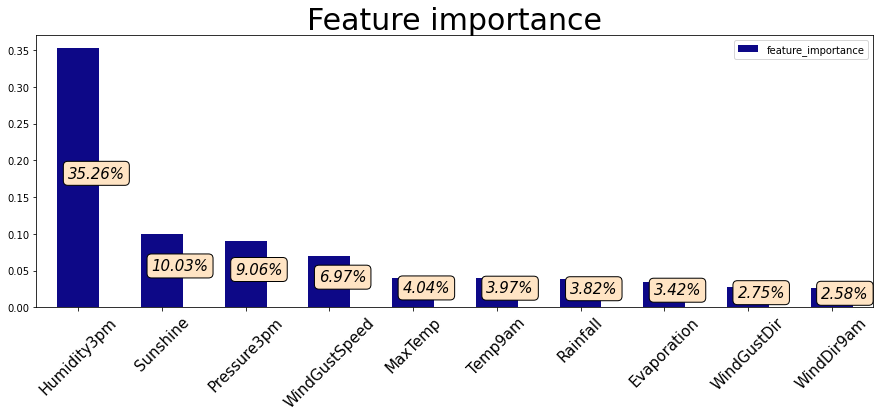

feature_importance
Humidity3pm                        0.352648
Sunshine                           0.100280
Pressure3pm                        0.090603
WindGustSpeed                      0.069687
MaxTemp                            0.040381
...                                     ...
CloudCategory_0                    0.000000
EvaporationCategory_30+            0.000000
Seasons_Winter                     0.000000
Same as_AliceSprings               0.000000
PressureCategory_1030+             0.000000

[122 rows x 1 columns]

In [210]:
charts.PlotFeatureImportance(X,Aus_dt1)

#### Predicting over the **training** set

In [221]:
X['TommorowRain_pred'] = Aus_dt1.predict(X)

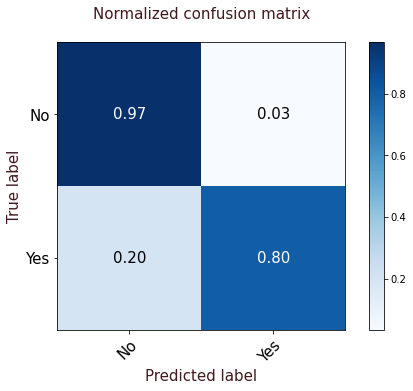



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.94      0.97      0.95     88219
         Yes       0.87      0.80      0.83     25528

    accuracy                           0.93    113747
   macro avg       0.91      0.88      0.89    113747
weighted avg       0.93      0.93      0.93    113747



In [222]:
charts.ClassicGraphicCM(X['TommorowRain_pred'],y,Aus_dt1.classes_,normalize=True)

#### **Test** dataset prediction

In [ ]:
X_test_colPick = pd.get_dummies(X_test.iloc[:,[22,3,4,5,6,7,8,9,11,14,16,18,19,21,24,27,30,31,32,33,34,35,36,37,38,39,40,41]])

In [ ]:
X_test_colPick['TommorowRain_pred'] = Aus_dt1.predict(X_test_colPick)

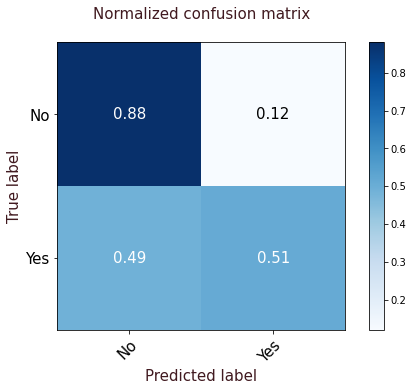



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.86      0.88      0.87     22096
         Yes       0.55      0.51      0.53      6349

    accuracy                           0.80     28445
   macro avg       0.71      0.69      0.70     28445
weighted avg       0.79      0.80      0.79     28445



In [ ]:
charts.ClassicGraphicCM(X_test_colPick['TommorowRain_pred'],y_test,Aus_dt1.classes_,normalize=True)

### Second run - Using **SelectKBest**  - 78% accuracy

#### Transformer  - Remove negative values so selektkbest can work

In [223]:
class PrepareForSelectKbestTransformer(BaseEstimator, TransformerMixin):
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    X_new=pd.get_dummies(X_new.drop(['Date','Location','Long','Nearest location'],axis=1))
    X_new.MaxTemp = X_new.MaxTemp + 10
    X_new.MinTemp = X_new.MinTemp + 10
    X_new.Latitude = X_new.Latitude + 50
    X_new.Temp9am = X_new.Temp9am + 10
    X_new.Temp3pm = X_new.Temp3pm + 10
    return X_new

In [224]:
PreSelectKbest = PrepareForSelectKbestTransformer()

#### Running the transformation and the model

In [238]:
KBestModel=SelectKBest(chi2, k=100)
tmpdf=PreSelectKbest.transform(X_train)
X_np =KBestModel.fit_transform(tmpdf, y_train)

# X_np is np array and we want it go back to data frame. The new dataframe is called X_new

mask = KBestModel.get_support() #list of booleans
new_features = [] # The list of  K best features

for bool, feature in zip(mask, tmpdf.columns):
    if bool:
        new_features.append(feature)

X_new=pd.DataFrame(X_np,columns=new_features,index=tmpdf.index)

In [239]:
Aus_dt2 = DecisionTreeClassifier(min_samples_leaf=5,class_weight='balanced')
Aus_dt2.fit(X_new, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### feature_importances

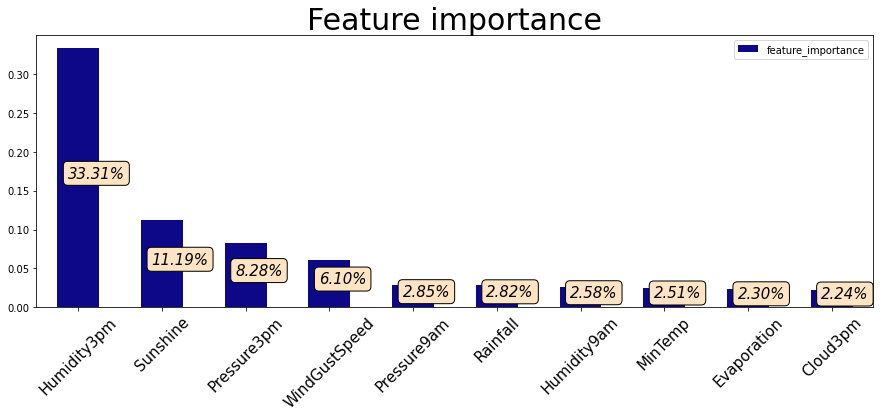

feature_importance
Humidity3pm                       0.333098
Sunshine                          0.111921
Pressure3pm                       0.082838
WindGustSpeed                     0.060987
Pressure9am                       0.028516
...                                    ...
rain_district_47                  0.000000
Area_Central                      0.000000
Same as_Woomera                   0.000000
Same as_MountGinini               0.000000
PressureCategory_1030+            0.000000

[100 rows x 1 columns]

In [240]:
charts.PlotFeatureImportance(X_new,Aus_dt2)

Predicting over the **TRAIN** dataset

In [241]:
X_new['TommorowRain_pred'] = Aus_dt2.predict(X_new)

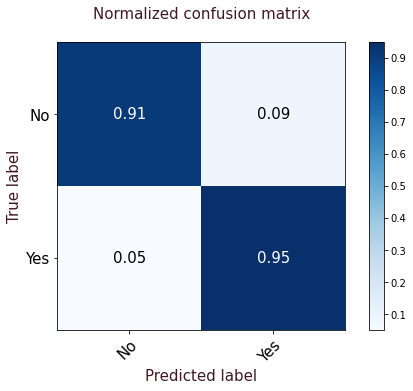



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.98      0.91      0.95     88219
         Yes       0.76      0.95      0.84     25528

    accuracy                           0.92    113747
   macro avg       0.87      0.93      0.90    113747
weighted avg       0.93      0.92      0.92    113747



In [242]:
charts.ClassicGraphicCM(X_new['TommorowRain_pred'],y_train,Aus_dt2.classes_,normalize=True)

#### Test dataset

In [243]:
X_test2=X_test.copy()

In [244]:
tmpdf_test=PreSelectKbest.transform(X_test2)

In [245]:
X_np =KBestModel.transform(tmpdf_test)

mask = KBestModel.get_support() #list of booleans
new_features = [] # The list of  K best features

for bool, feature in zip(mask, tmpdf_test.columns):
    if bool:
        new_features.append(feature)

X_new_test=pd.DataFrame(X_np,columns=new_features,index=tmpdf_test.index)

In [246]:
X_new_test['TommorowRain_pred'] = Aus_dt2.predict(X_new_test)

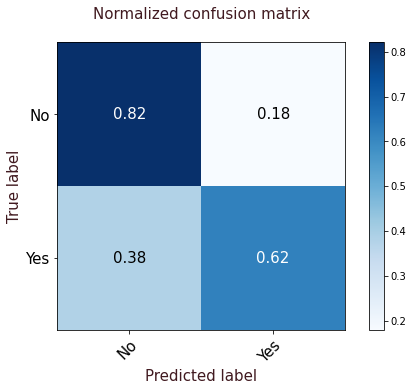



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.88      0.82      0.85     22096
         Yes       0.50      0.62      0.55      6349

    accuracy                           0.78     28445
   macro avg       0.69      0.72      0.70     28445
weighted avg       0.80      0.78      0.78     28445



In [247]:
charts.ClassicGraphicCM(X_new_test['TommorowRain_pred'],y_test,Aus_dt2.classes_,normalize=True)

## logistic regression - 85% accuracy

In [248]:
df4=pd.get_dummies(X_train.iloc[:,[22,3,4,5,6,7,8,9,11,14,16,18,19,21,24,27,30,31,32,33,34,35,36,37,38,39,40,41]])

In [249]:
df44 = pd.get_dummies(X_test.iloc[:,[22,3,4,5,6,7,8,9,11,14,16,18,19,21,24,27,30,31,32,33,34,35,36,37,38,39,40,41]])

In [250]:
scaler = MinMaxScaler()

X_train2 = scaler.fit_transform(df4)
X_test2 = scaler.transform(df44)

In [251]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train2, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Predicting over **Training** set

In [252]:
y_pred_train = logreg.predict(X_train2)

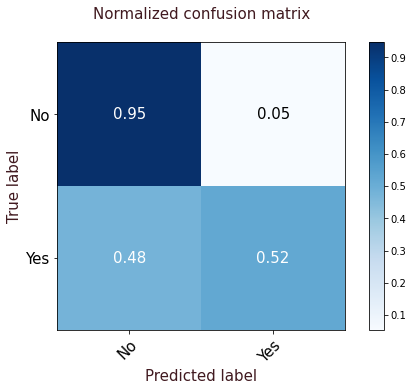



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.87      0.95      0.91     88219
         Yes       0.74      0.52      0.61     25528

    accuracy                           0.85    113747
   macro avg       0.81      0.73      0.76    113747
weighted avg       0.84      0.85      0.84    113747



In [253]:
charts.ClassicGraphicCM(y_pred_train,y,logreg.classes_,normalize=True)

Predicting over **Test** set

In [255]:
y_pred_test = logreg.predict(X_test2)

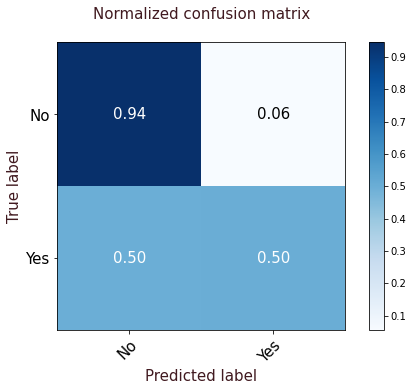



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.87      0.94      0.91     22096
         Yes       0.72      0.50      0.59      6349

    accuracy                           0.85     28445
   macro avg       0.80      0.72      0.75     28445
weighted avg       0.84      0.85      0.84     28445



In [256]:
charts.ClassicGraphicCM(y_pred_test,y_test,logreg.classes_,normalize=True)

## Random forest - 85% accuracy

### Training the model

In [257]:
PreSelectKbest = PrepareForSelectKbestTransformer()

In [258]:
rf_model1 = RandomForestClassifier(n_estimators= 200,max_features ='auto' ,  min_samples_leaf= 10, class_weight= 'balanced',random_state=1234)

In [259]:
KBestModel=SelectKBest(chi2, k=100)
X_df=PreSelectKbest.transform(X_train)
X_np =KBestModel.fit_transform(X_df, y_train)

mask = KBestModel.get_support() #list of booleans
new_features = [] # The list of  K best features

for bool, feature in zip(mask, X_df.columns):
    if bool:
        new_features.append(feature)

X_new=pd.DataFrame(X_np,columns=new_features,index=X_df.index)

Predicting over **Training** set

In [260]:
rf_model1.fit(X_new, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

#### feature_importances

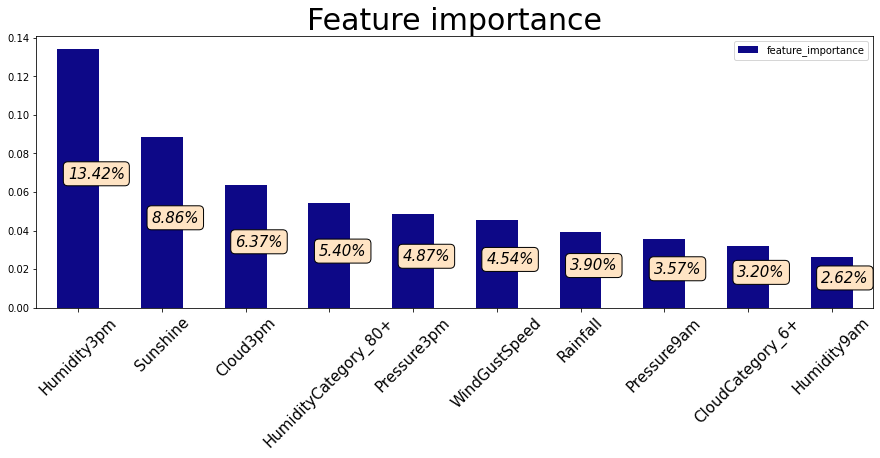

feature_importance
Humidity3pm                          0.134183
Sunshine                             0.088563
Cloud3pm                             0.063681
HumidityCategory_80+                 0.054036
Pressure3pm                          0.048679
...                                       ...
rain_district_47                     0.000075
Same as_AliceSprings                 0.000033
RainfallCategory_60+                 0.000017
Same as_Uluru                        0.000013
EvaporationCategory_00-00            0.000003

[100 rows x 1 columns]

In [261]:
charts.PlotFeatureImportance(X_new,rf_model1)

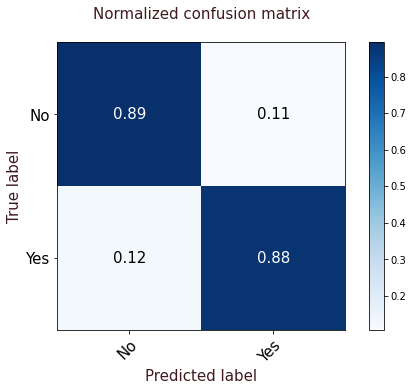



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.96      0.89      0.93     88219
         Yes       0.70      0.88      0.78     25528

    accuracy                           0.89    113747
   macro avg       0.83      0.89      0.85    113747
weighted avg       0.90      0.89      0.89    113747



In [ ]:
charts.ClassicGraphicCM(rf_model1.predict(X_new),y_train,rf_model1.classes_,normalize=True)

### Predicting over **Test** set

In [262]:
x_tsetDF=PreSelectKbest.transform(X_test)
X_np =KBestModel.transform(x_tsetDF)

mask = KBestModel.get_support() #list of booleans
new_features = [] # The list of  K best features

for bool, feature in zip(mask, x_tsetDF.columns):
    if bool:
        new_features.append(feature)

X_new_test=pd.DataFrame(X_np,columns=new_features,index=x_tsetDF.index)

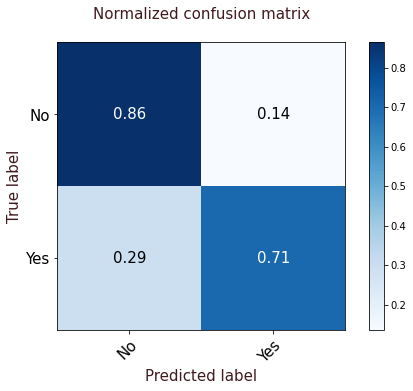



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.91      0.86      0.89     22096
         Yes       0.60      0.71      0.65      6349

    accuracy                           0.83     28445
   macro avg       0.75      0.78      0.77     28445
weighted avg       0.84      0.83      0.83     28445



In [263]:
 charts.ClassicGraphicCM(rf_model1.predict(X_new_test),y_test,rf_model1.classes_,normalize=True)

### Grid search on Random forest

In [ ]:
my_param_grid = {'max_depth': [20,50,100,200],
                 'min_samples_leaf' : [5,10,20],
                 'class_weight': ['balanced',{'Yes':0.5,'No':0.5},{'Yes':0.6,'No':0.4}]}

In [ ]:
clf_gs = GridSearchCV(rf_model1, my_param_grid)
clf_gs.fit(X_new, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=10,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False,
                                         

Extract best estimator

In [ ]:
print(clf_gs.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={'No': 0.5, 'Yes': 0.5}, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=1234, verbose=0, warm_start=False)


Predicting over the **training** model

In [ ]:
clf_gs.best_estimator_.classes_

array(['No', 'Yes'], dtype=object)

In [ ]:
y_GS_pred_train=clf_gs.predict(X_new)

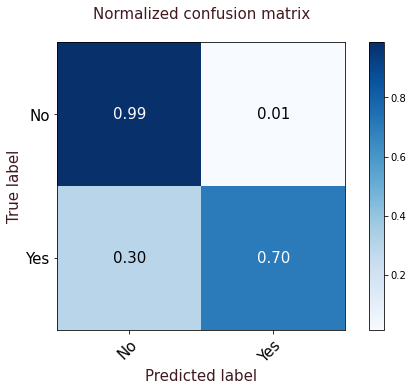



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.92      0.99      0.95     88219
         Yes       0.94      0.70      0.80     25528

    accuracy                           0.92    113747
   macro avg       0.93      0.84      0.88    113747
weighted avg       0.92      0.92      0.92    113747



In [ ]:
 charts.ClassicGraphicCM(y_GS_pred_train,y_train,clf_gs.best_estimator_.classes_,normalize=True)

Predicting over the **Test** dataset

In [ ]:
y_GS_pred=clf_gs.predict(X_new_test)

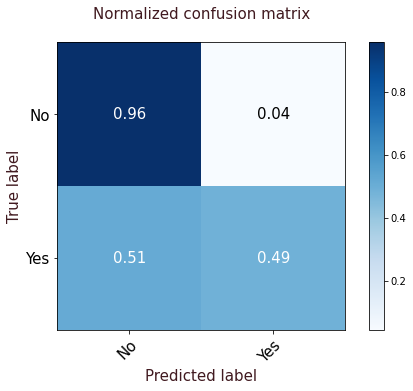



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.87      0.96      0.91     22096
         Yes       0.76      0.49      0.59      6349

    accuracy                           0.85     28445
   macro avg       0.81      0.72      0.75     28445
weighted avg       0.84      0.85      0.84     28445



In [ ]:
charts.ClassicGraphicCM(y_GS_pred,y_test,clf_gs.best_estimator_.classes_,normalize=True)

## XGBOOST - 86% accuracy

In [ ]:
xgb_model = XGBClassifier( random_state=1234,n_estimators= 500,max_depth=50,)
xgb_model.fit(X_new, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Predicting over **Training** set

In [ ]:
y_X_train=xgb_model.predict(X_new)

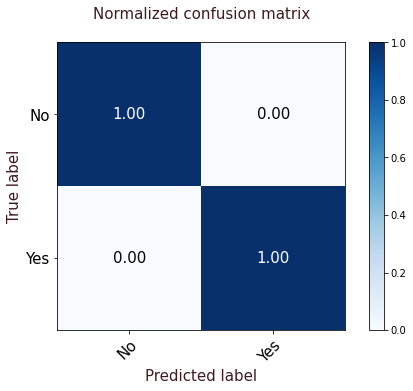



Classification_report
*********************

              precision    recall  f1-score   support

          No       1.00      1.00      1.00     88219
         Yes       1.00      1.00      1.00     25528

    accuracy                           1.00    113747
   macro avg       1.00      1.00      1.00    113747
weighted avg       1.00      1.00      1.00    113747



In [ ]:
charts.ClassicGraphicCM(y_X_train,y_train,xgb_model.classes_,normalize=True)

### Predicting over **Test** set

In [ ]:
y_tst_prd=xgb_model.predict(X_new_test)

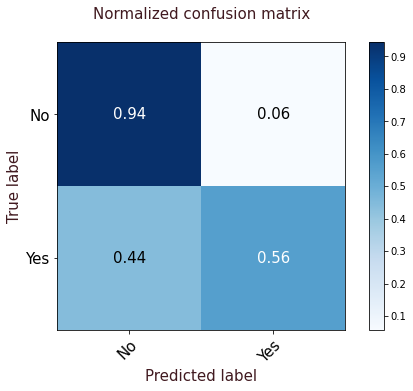



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.88      0.94      0.91     22096
         Yes       0.74      0.56      0.63      6349

    accuracy                           0.86     28445
   macro avg       0.81      0.75      0.77     28445
weighted avg       0.85      0.86      0.85     28445



In [ ]:
charts.ClassicGraphicCM(y_tst_prd,y_test,xgb_model.classes_,normalize=True)


# Running combined models - 90% accuracy

### Running a combined models sliced by each 'climate' value - 90% accuracy

Lets start by preparing the data - again.

In [264]:
class PrepareForSelectKbestTransformer(BaseEstimator, TransformerMixin):
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    X_new=pd.get_dummies(X_new.drop(['Date','Location','Long','Nearest location'],axis=1))
    X_new.MaxTemp = X_new.MaxTemp + 10
    X_new.MinTemp = X_new.MinTemp + 10
    X_new.Latitude = X_new.Latitude + 50
    X_new.Temp9am = X_new.Temp9am + 10
    X_new.Temp3pm = X_new.Temp3pm + 10
    return X_new

In [265]:
PreSelectKbest = PrepareForSelectKbestTransformer()

In [266]:
KBestModel=SelectKBest(chi2, k=100)
X_df=PreSelectKbest.transform(X_train)
X_np =KBestModel.fit_transform(X_df, y_train)

mask = KBestModel.get_support() #list of booleans
new_features = [] # The list of  K best features

for bool, feature in zip(mask, X_df.columns):
    if bool:
        new_features.append(feature)

X_new=pd.DataFrame(X_np,columns=new_features,index=X_df.index)

In [267]:
x_tsetDF=PreSelectKbest.transform(X_test)
X_np =KBestModel.transform(x_tsetDF)

mask = KBestModel.get_support() #list of booleans
new_features = [] # The list of  K best features

for bool, feature in zip(mask, x_tsetDF.columns):
    if bool:
        new_features.append(feature)

X_new_test=pd.DataFrame(X_np,columns=new_features,index=x_tsetDF.index)

In [268]:
X_new['Climate']=X_train['Climate']
X_new_test['Climate']=X_test['Climate']

In [269]:
climates = X_new['Climate'].unique()

**Create a model for each climate value**

In [ ]:
PredPerClimateDir = {}
for clm in climates:
    print('Start:' + str(clm))
    X_new2 = X_new[X_new['Climate']==clm]
    X_new_test2 = X_new_test[X_new_test['Climate']==clm]
    y_train2 = y_train[X_new['Climate']==clm]
    y_test2 = y_test[X_new_test['Climate']==clm]
    X_new2=X_new2.drop(['Climate'],axis=1)
    X_new_test2 = X_new_test2.drop(['Climate'],axis=1)
    xgb_model2 = XGBClassifier( random_state=1234,n_estimators= 500,max_depth=50,min_child_weight=3)
    xgb_model2.fit(X_new2, y_train2)
    y_tst_prd = xgb_model2.predict(X_new_test2)
    PredPerClimateDir[clm] = {'y_pred':pd.Series(y_tst_prd,name='y_pred',index=X_new_test2.index),'model':xgb_model2}

Start:Cfb


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Start:Aw
Start:Csa
Start:Cfa
Start:Bwh
Start:Csb
Start:Am
Start:Bsh
Start:Bsk


Combine all models results - running on **Test** set

In [ ]:
flag = True
for clm in PredPerClimateDir.keys():
    if flag:
        DF = pd.DataFrame(PredPerClimateDir[clm],columns=['y_pred'],index=PredPerClimateDir[clm]['y_pred'].index)
        DF['Climate'] = clm
        flag=False
    else:
        CurrDF = pd.DataFrame(PredPerClimateDir[clm],columns=['y_pred'],index=PredPerClimateDir[clm]['y_pred'].index)
        CurrDF['Climate'] = clm
        DF = DF.append(CurrDF)

DF = DF.reindex(X_new_test2.index.tolist())

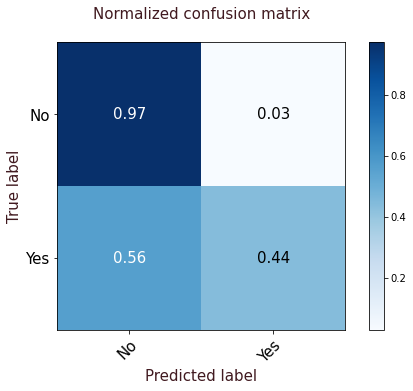



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.92      0.97      0.94      1023
         Yes       0.70      0.44      0.54       160

    accuracy                           0.90      1183
   macro avg       0.81      0.70      0.74      1183
weighted avg       0.89      0.90      0.89      1183



In [ ]:
charts.ClassicGraphicCM(DF['y_pred'],y_test2,xgb_model2.classes_,normalize=True)

### Running a combined models sliced by each **rain district** value -

### **90%** accuracy with **much better score over the YES class**

Lets start by preparing the data - again.

In [270]:
class PrepareForSelectKbestTransformer(BaseEstimator, TransformerMixin):
  def fit(self,X,y=None):
    return self
  def transform(self, X):
    X_new = X.copy()
    X_new=pd.get_dummies(X_new.drop(['Date','Location','Long','Nearest location'],axis=1))
    X_new.MaxTemp = X_new.MaxTemp + 10
    X_new.MinTemp = X_new.MinTemp + 10
    X_new.Latitude = X_new.Latitude + 50
    X_new.Temp9am = X_new.Temp9am + 10
    X_new.Temp3pm = X_new.Temp3pm + 10
    return X_new

In [271]:
PreSelectKbest = PrepareForSelectKbestTransformer()

In [272]:
KBestModel=SelectKBest(chi2, k=100)
X_df=PreSelectKbest.transform(X_train)
X_np =KBestModel.fit_transform(X_df, y_train)

mask = KBestModel.get_support() #list of booleans
new_features = [] # The list of  K best features

for bool, feature in zip(mask, X_df.columns):
    if bool:
        new_features.append(feature)

X_new=pd.DataFrame(X_np,columns=new_features,index=X_df.index)

In [273]:
x_tsetDF=PreSelectKbest.transform(X_test)
X_np =KBestModel.transform(x_tsetDF)

mask = KBestModel.get_support() #list of booleans
new_features = [] # The list of  K best features

for bool, feature in zip(mask, x_tsetDF.columns):
    if bool:
        new_features.append(feature)

X_new_test=pd.DataFrame(X_np,columns=new_features,index=x_tsetDF.index)

In [274]:
X_new['rain_district']=X_train['rain_district']
X_new_test['rain_district']=X_test['rain_district']

In [275]:
RainDistricts = X_new['rain_district'].unique()

**Create a model for each rain_district value**

In [276]:
PredPerClimateDir = {}
for RD in RainDistricts:
    print('Start:' + str(RD))
    X_new2 = X_new[X_new['rain_district']==RD]
    X_new_test2 = X_new_test[X_new_test['rain_district']==RD]
    y_train2 = y_train[X_new['rain_district']==RD]
    y_test2 = y_test[X_new_test['rain_district']==RD]
    X_new2=X_new2.drop(['rain_district'],axis=1)
    X_new_test2 = X_new_test2.drop(['rain_district'],axis=1)
    xgb_model2 = XGBClassifier( random_state=1234,n_estimators= 500,max_depth=50,min_child_weight=3)
    xgb_model2.fit(X_new2, y_train2)
    y_tst_prd = xgb_model2.predict(X_new_test2)
    PredPerClimateDir[RD] = {'y_pred':pd.Series(y_tst_prd,name='y_pred',index=X_new_test2.index),'model':xgb_model2}

Start:70


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Start:66
Start:86
Start:40
Start:14GA
Start:94
Start:23A
Start:9
Start:67
Start:61
Start:90
Start:15B
Start:32
Start:81
Start:91
Start:87
Start:9A
Start:31
Start:72
Start:68
Start:85
Start:100
Start:47
Start:23C
Start:48
Start:10A
Start:59
Start:21
Start:53
Start:26


Combine all models results - running on **Test** set

In [277]:
flag = True
for clm in PredPerClimateDir.keys():
    if flag:
        DF = pd.DataFrame(PredPerClimateDir[clm],columns=['y_pred'],index=PredPerClimateDir[clm]['y_pred'].index)
        DF['Climate'] = clm
        flag=False
    else:
        CurrDF = pd.DataFrame(PredPerClimateDir[clm],columns=['y_pred'],index=PredPerClimateDir[clm]['y_pred'].index)
        CurrDF['Climate'] = clm
        DF = DF.append(CurrDF)

DF = DF.reindex(X_new_test2.index.tolist())

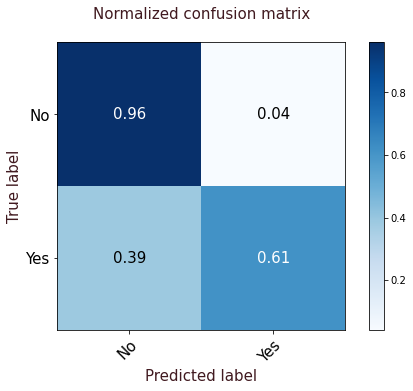



Classification_report
*********************

              precision    recall  f1-score   support

          No       0.93      0.96      0.94       497
         Yes       0.75      0.61      0.67        96

    accuracy                           0.90       593
   macro avg       0.84      0.79      0.81       593
weighted avg       0.90      0.90      0.90       593



In [278]:
charts.ClassicGraphicCM(DF['y_pred'],y_test2,xgb_model2.classes_,normalize=True)

# Save the best model on drive

In [279]:
import pickle
with open(my_path + '/XGBOOST_Per_rain_district', 'wb') as MultiMCFile:
    pickle.dump(DF, MultiMCFile)